# Lunar Survival Challenge Multi-Agent System Implementation
Implemented a comprehensive collaborative agent-based system for the lunar survival challenge. The system follows our redesigned workflow with paired agent teams and a focus on deeper collaboration.

In [3]:
import os
import json
import logging
from typing import List, Dict, Any, Optional, Tuple
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI
#from fpdf2 import FPDF  # For PDF generation

from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.units import inch
import re


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler("lunar_survival_agents.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()

class Agent:
    """Base agent class for lunar survival challenge."""
    
    def __init__(self, 
                 instruction: str, 
                 role: str, 
                 expertise_description: str,
                 examples: Optional[List[Dict[str, str]]] = None):
        """
        Initialize an LLM-based agent with a specific role.
        
        Args:
            instruction: The system instruction for the agent
            role: The role of the agent (e.g., "Science Analyst")
            expertise_description: Description of the agent's expertise
            examples: Optional examples to include in the prompt
        """
        self.instruction = instruction
        self.role = role
        self.expertise_description = expertise_description
        self.examples = examples or []
        self.conversation_history = []
        
        # Initialize LLM
        self.client = AzureChatOpenAI(
            azure_deployment="VARELab-GPT4o",
            api_key=os.environ.get('AZURE_OPENAI_VARE_KEY'),
            api_version="2024-08-01-preview",
            azure_endpoint=os.environ.get('AZURE_ENDPOINT'),
            temperature=0.5
        )
        
        # Build initial system message
        self.messages = [
            {"role": "system", "content": self._build_system_prompt()}
        ]
        
        # Add example conversations if provided
        if self.examples:
            for example in self.examples:
                self.messages.append({"role": "user", "content": example['question']})
                self.messages.append({
                    "role": "assistant", 
                    "content": example['answer'] + "\n\n" + example.get('reason', '')
                })
                
        logger.info(f"Initialized {self.role} agent")
    
    def _build_system_prompt(self) -> str:
        """Build the system prompt for the agent."""
        prompt = f"You are a {self.role} who {self.expertise_description}. {self.instruction}"
        return prompt
    
    def chat(self, message: str) -> str:
        """
        Send a message to the agent and get a response.
        
        Args:
            message: The message to send to the agent
            
        Returns:
            The agent's response
        """
        logger.info(f"[{self.role}] Received message: {message[:100]}...")
        
        # Add the user message to the conversation
        self.messages.append({"role": "user", "content": message})
        
        # Get response from LLM
        response = self.client.predict_messages(
            messages=self.messages
        )
        
        # Extract and store the response
        assistant_message = response.content
        self.messages.append({"role": "assistant", "content": assistant_message})
        self.conversation_history.append({"user": message, "assistant": assistant_message})
        
        logger.info(f"[{self.role}] Responded: {assistant_message[:100]}...")
        
        return assistant_message
    
    def get_conversation_history(self) -> List[Dict[str, str]]:
        """Get the conversation history."""
        return self.conversation_history


class WebResearchAgent(Agent):
    """Agent specialized in web research for gathering information."""
    
    def __init__(self):
        super().__init__(
            instruction="You specialize in gathering factual information from the web. Focus on obtaining accurate data about the lunar environment and survival in space.",
            role="Web Researcher",
            expertise_description="specializes in gathering and synthesizing information from web sources"
        )
    
    def research(self, query: str) -> str:
        """
        Perform research on a specific query.
        
        Args:
            query: The research query
            
        Returns:
            Research findings
        """
        # In a real implementation, this would use langchain's WebBrowser tool
        # Since we can't directly use that here, we'll simulate with a focused prompt
        
        research_prompt = f"""
        You need to research: "{query}"
        
        As a Web Researcher, your task is to provide accurate information as if you've researched this topic.
        
        Focus on:
        1. Scientific facts about the lunar environment
        2. NASA procedures and protocols
        3. Survival requirements in space
        4. Properties of survival equipment in space
        
        Provide a comprehensive synthesis of this information in a factual, well-structured format.
        Include specific details about the lunar environment such as:
        - No atmosphere (vacuum)
        - Extreme temperature variations
        - Radiation exposure
        - Low gravity (1/6 of Earth)
        - Lunar dust properties
        
        Cite relevant NASA knowledge about survival priorities in space.
        """
        
        logger.info(f"[Web Researcher] Researching: {query}")
        research_results = self.chat(research_prompt)
        
        return research_results


class Team:
    """Represents a collaborative team of agents working together."""
    
    def __init__(self, 
                 name: str, 
                 goal: str, 
                 members: List[Dict[str, str]],
                 examples: Optional[List[Dict[str, str]]] = None):
        """
        Initialize a team of agents.
        
        Args:
            name: Name of the team
            goal: The shared goal of the team
            members: List of member information (role, expertise_description)
            examples: Optional examples to include in agent prompts
        """
        self.name = name
        self.goal = goal
        self.examples = examples
        self.agents = []
        self.team_conversation = []
        
        logger.info(f"Initializing {name} team with goal: {goal}")
        
        # Create agents based on member information
        for member_info in members:
            agent = Agent(
                instruction=f"You are part of the {name} team. Your goal is to {goal}.",
                role=member_info['role'],
                expertise_description=member_info['expertise_description'],
                examples=examples
            )
            self.agents.append(agent)
    
    def collaborate(self, topic: str, rounds: int = 2) -> List[Dict[str, str]]:
        """
        Facilitate collaboration between team members.

        Args:
            topic: The topic for collaboration
            rounds: Number of discussion rounds (default now 2)

        Returns:
            Conversation records
        """
        logger.info(f"[{self.name} Team] Starting collaboration on: {topic}")

        conversation_records = []

        # Initial prompt to each agent
        initial_responses = []
        for agent in self.agents:
            response = agent.chat(
                f"As a {agent.role}, please provide your initial thoughts on: {topic}"
            )
            initial_responses.append({
                "role": agent.role,
                "response": response
            })
            conversation_records.append({
                "round": 0,
                "agent": agent.role,
                "message": response
            })

        # Limit to exactly 2 rounds of collaboration (regardless of input parameter)
        for round_num in range(1, 3):  # Always 2 rounds
            logger.info(f"[{self.name} Team] Starting collaboration round {round_num}")

            # Each agent responds to the previous round
            for i, agent in enumerate(self.agents):
                # Get the other agent's response from previous round
                other_agent = self.agents[1 - i]  # For 2 agents
                other_response = initial_responses[1 - i]["response"] if round_num == 1 else conversation_records[-2]["message"]

                prompt = f"""
                Your teammate ({other_agent.role}) said: 

                "{other_response}"

                Based on your expertise as a {agent.role} and considering your teammate's perspective, 
                please refine your analysis or provide additional insights on {topic}.
                If you agree with certain points, acknowledge them.
                If you have different perspectives, explain your reasoning.
                Work toward developing an integrated viewpoint with your teammate.
                """

                response = agent.chat(prompt)
                conversation_records.append({
                    "round": round_num,
                    "agent": agent.role,
                    "message": response
                })

        # Final consensus
        logger.info(f"[{self.name} Team] Generating final consensus")

        consensus_prompt = f"""
        Review the entire discussion your team has had about {topic}.
        As a {self.agents[0].role}, collaborate with your teammate to provide a final consensus view that
        integrates both of your perspectives. This should represent your team's collective expertise and judgment.

        Ensure your final output includes a clear, numbered ranking of all items from 1 (most important) to 15 (least important),
        with brief but specific justifications for each ranking position.
        """

        consensus_response = self.agents[0].chat(consensus_prompt)
        conversation_records.append({
            "round": "consensus",
            "agent": f"{self.name} Team",
            "message": consensus_response
        })

        self.team_conversation = conversation_records

        # Log full conversation to file
        self._log_conversation_to_file()

        return conversation_records
    
    def _log_conversation_to_file(self):
        """Log the full conversation to a separate file for review."""
        filename = f"{self.name.replace(' ', '_').lower()}_conversation.txt"
        
        with open(filename, "w", encoding="utf-8") as f:
            f.write(f"=== {self.name} Team Conversation ===\n\n")
            f.write(f"Goal: {self.goal}\n\n")
            
            for entry in self.team_conversation:
                f.write(f"Round: {entry['round']}\n")
                f.write(f"Agent: {entry['agent']}\n")
                f.write(f"Message:\n{entry['message']}\n\n")
                f.write("-" * 80 + "\n\n")
        
        logger.info(f"[{self.name} Team] Conversation log saved to {filename}")


## LunarSurvivalSystem class

In [5]:
class LunarSurvivalSystem:
    """Main system for lunar survival challenge."""
    
    def __init__(self):
        """Initialize the lunar survival system with teams and meta agent."""
        
        logger.info("Initializing Lunar Survival System")
        
        # Define correct lunar survival items
        self.survival_items = [
            {"name": "Box of matches", "description": "Standard matches for lighting fire"},
            {"name": "Food concentrate", "description": "Dehydrated food for consumption"},
            {"name": "50 feet of nylon rope", "description": "Strong utility rope"},
            {"name": "Parachute silk", "description": "Large sheet of parachute silk"},
            {"name": "Portable heating unit", "description": "Device for generating heat"},
            {"name": "Two .45 caliber pistols", "description": "Firearms with ammunition"},
            {"name": "One case of dehydrated milk", "description": "Powdered milk for consumption"},
            {"name": "Two 100 lb. tanks of oxygen", "description": "Compressed oxygen supply"},
            {"name": "Stellar map", "description": "Map of the moon's constellation"},
            {"name": "Self-inflating life raft", "description": "Inflatable raft"},
            {"name": "Magnetic compass", "description": "Navigation tool"},
            {"name": "20 liters of water", "description": "Potable water supply"},
            {"name": "Signal flares", "description": "Visual emergency signaling devices"},
            {"name": "First aid kit, including injection needle", "description": "Medical supplies"},
            {"name": "Solar-powered FM receiver-transmitter", "description": "Communication device"}
        ]
        
        # Create web research agent
        self.web_researcher = WebResearchAgent()
        
        # Create knowledge acquisition team
        self.knowledge_team = Team(
            name="Knowledge Acquisition",
            goal="gather and analyze information about the lunar environment and human survival needs",
            members=[
                {
                    "role": "Science Analyst",
                    "expertise_description": "specializes in lunar physics, environmental conditions, and how items function in the lunar environment"
                },
                {
                    "role": "Resource Analyst",
                    "expertise_description": "specializes in human physiological needs, survival requirements, and resource management in extreme conditions"
                }
            ]
        )
        
        # Create technical reasoning team
        self.technical_team = Team(
            name="Technical Reasoning",
            goal="evaluate items based on scientific principles and established space procedures",
            members=[
                {
                    "role": "Science Reasoner",
                    "expertise_description": "applies scientific knowledge to evaluate how effectively items will function in the lunar environment"
                },
                {
                    "role": "Protocol Reasoner",
                    "expertise_description": "applies standard space agency procedures and protocols to evaluate items based on established guidelines"
                }
            ]
        )
        
        # Create practical reasoning team
        self.practical_team = Team(
            name="Practical Reasoning",
            goal="evaluate items based on survival needs and contingency planning",
            members=[
                {
                    "role": "Resource Reasoner",
                    "expertise_description": "optimizes resource allocation based on survival hierarchy and human needs"
                },
                {
                    "role": "Creative Reasoner",
                    "expertise_description": "considers edge cases, alternative item uses, and unexpected scenarios"
                }
            ]
        )
        
        # Create meta reasoning agent
        self.meta_agent = Agent(
            instruction="You are responsible for integrating multiple team perspectives and making final decisions.",
            role="Meta Reasoner",
            expertise_description="specializes in holistic reasoning, conflict resolution, and integrated decision making"
        )
        
        # Track system state
        self.knowledge_base = {}
        self.technical_ranking = []
        self.practical_ranking = []
        self.final_ranking = []
        self.justifications = {}
        
    #################################################################################

    def _web_research_phase(self):
        """
        Execute the web research phase to gather information about lunar survival.
        """
        logger.info("Starting Web Research Phase...")

        # Research lunar environment
        lunar_env_research = self.web_researcher.research(
            "Lunar environment characteristics and challenges for human survival on the moon"
        )

        # Research survival principles
        survival_research = self.web_researcher.research(
            "NASA protocols and guidelines for survival in space emergencies"
        )

        # Research specific items
        items_research = self.web_researcher.research(
            "Effectiveness of various equipment in lunar environment: oxygen tanks, water, signal flares, communication devices, matches, food, compass, weapons"
        )

        # Store research results
        self.knowledge_base["web_research"] = {
            "lunar_environment": lunar_env_research,
            "survival_protocols": survival_research,
            "items_analysis": items_research
        }

        # Save research to file for review
        with open("web_research_results.txt", "w", encoding="utf-8") as f:
            f.write("=== Web Research Results ===\n\n")
            f.write("LUNAR ENVIRONMENT RESEARCH:\n")
            f.write(lunar_env_research)
            f.write("\n\n" + "-" * 80 + "\n\n")
            f.write("SURVIVAL PROTOCOLS RESEARCH:\n")
            f.write(survival_research)
            f.write("\n\n" + "-" * 80 + "\n\n")
            f.write("ITEMS ANALYSIS RESEARCH:\n")
            f.write(items_research)

        logger.info("Web Research Phase completed.")
        return self.knowledge_base["web_research"]

    ##################################################################################

    def _knowledge_acquisition_phase(self):
        """
        Execute the knowledge acquisition phase where agents gather and integrate 
        knowledge about lunar environment and survival needs.
        """
        logger.info("Starting Knowledge Acquisition Phase...")

        # First, get web research
        web_research = self._web_research_phase()

        # Step 1: Gather lunar environmental information with web research input
        lunar_environment_prompt = f"""
        As a Science Analyst, your task is to gather comprehensive information about the lunar environment.

        Use this web research as a starting point:
        {web_research['lunar_environment']}

        Focus on:
        1. Physical conditions (vacuum, temperature extremes, radiation, gravity)
        2. Surface characteristics (terrain, dust, etc.)
        3. Day/night cycle and their implications
        4. How these conditions would affect the functioning of various items and human survival


        Premise: You are a member of a space crew originally scheduled to rendezvous with a mother ship on the lighted surface of the moon. However, due to mechanical difficulties, your ship was forced to land at a spot some 200 miles from the rendezvous point. During reentry and landing, much of the equipment aboard was damaged and, since survival depends on reaching the mother ship, the most critical items available must be chosen for the 200-mile trip. Below are listed the 15 items left intact and undamaged after landing. Your task is to rank order them in terms of their importance for your crew in allowing them to reach the rendezvous point. Place the number 1 by the most important item, the number 2 by the second most important, and so on through number 15 for the least important.
        Review the following items that need to be evaluated:
        {', '.join([item["name"] for item in self.survival_items])}

        Provide a structured knowledge base that will be useful for evaluating these specific survival items.
        """

        # Step 2: Gather human survival needs information with web research input
        survival_needs_prompt = f"""
        As a Resource Analyst, your task is to gather comprehensive information about human survival needs in the lunar environment.

        Use this web research as a starting point:
        {web_research['survival_protocols']}

        Focus on:
        1. Basic physiological needs (oxygen, water, food, temperature regulation)
        2. Timeframes for various survival needs (how long before critical failure)
        3. Special considerations for the lunar environment
        4. Hierarchy of survival priorities according to NASA protocols

        Premise: You are a member of a space crew originally scheduled to rendezvous with a mother ship on the lighted surface of the moon. However, due to mechanical difficulties, your ship was forced to land at a spot some 200 miles from the rendezvous point. During reentry and landing, much of the equipment aboard was damaged and, since survival depends on reaching the mother ship, the most critical items available must be chosen for the 200-mile trip. Below are listed the 15 items left intact and undamaged after landing. Your task is to rank order them in terms of their importance for your crew in allowing them to reach the rendezvous point. Place the number 1 by the most important item, the number 2 by the second most important, and so on through number 15 for the least important.
        Review the following items that need to be evaluated:
        {', '.join([item["name"] for item in self.survival_items])}

        Provide a structured knowledge base that will be useful for evaluating these specific survival items.
        """

        # Get responses from knowledge team
        env_response = self.knowledge_team.agents[0].chat(lunar_environment_prompt)
        needs_response = self.knowledge_team.agents[1].chat(survival_needs_prompt)

        # Step 3: Collaborative knowledge integration
        integration_prompt = f"""
        You need to collaborate to create an integrated knowledge base for lunar survival.

        The Science Analyst has provided information about the lunar environment:
        {env_response}

        The Resource Analyst has provided information about human survival needs:
        {needs_response}

        Additional items analysis from research:
        {web_research['items_analysis']}

        Work together to create an integrated knowledge framework that connects:
        1. Environmental challenges with human survival needs
        2. How different environmental factors affect survival priorities
        3. Critical timeframes and dependencies
        4. Specific analysis of how each item on our list would function on the moon

        This integrated knowledge will be used to evaluate survival items, so make it practical and comprehensive.

        Premise: You are a member of a space crew originally scheduled to rendezvous with a mother ship on the lighted surface of the moon. However, due to mechanical difficulties, your ship was forced to land at a spot some 200 miles from the rendezvous point. During reentry and landing, much of the equipment aboard was damaged and, since survival depends on reaching the mother ship, the most critical items available must be chosen for the 200-mile trip. Below are listed the 15 items left intact and undamaged after landing. Your task is to rank order them in terms of their importance for your crew in allowing them to reach the rendezvous point. Place the number 1 by the most important item, the number 2 by the second most important, and so on through number 15 for the least important.
        Review the following items that need to be evaluated:
        {', '.join([item["name"] for item in self.survival_items])}
        """

        # Collaborative knowledge integration through team discussion
        knowledge_integration = self.knowledge_team.collaborate(
            topic=integration_prompt,
            rounds=2
        )

        # Extract the final consensus as our knowledge base
        integrated_knowledge = knowledge_integration[-1]["message"]

        # Store structured knowledge in our system
        self.knowledge_base = {
            "web_research": web_research,
            "lunar_environment": env_response,
            "survival_needs": needs_response,
            "integrated_knowledge": integrated_knowledge
        }

        # Format knowledge for reasoning teams
        self._prepare_knowledge_for_reasoning_teams()

        logger.info("Knowledge Acquisition Phase completed.")
        return self.knowledge_base

    ##################################################################################

    def _prepare_knowledge_for_reasoning_teams(self):
        """
        Prepare knowledge in a format suitable for reasoning teams.
        This includes extracting key principles and facts from the knowledge base.
        """
        # Extract key environmental principles
        env_principles_prompt = f"""
        Based on this knowledge about the lunar environment:

        {self.knowledge_base['lunar_environment']}

        Please extract 10-15 key scientific principles that are most relevant for evaluating these survival items:
        {', '.join([item["name"] for item in self.survival_items])}

        Format as a numbered list of concise statements that can be directly used by the reasoning teams.
        """
        env_principles = self.knowledge_team.agents[0].chat(env_principles_prompt)

        # Extract key survival principles
        survival_principles_prompt = f"""
        Based on this knowledge about human survival needs:

        {self.knowledge_base['survival_needs']}

        Please extract 10-15 key survival principles that are most relevant for evaluating these survival items:
        {', '.join([item["name"] for item in self.survival_items])}

        Format as a numbered list of concise statements that can be directly used by the reasoning teams.
        Include time-critical factors and priority hierarchies.
        """
        survival_principles = self.knowledge_team.agents[1].chat(survival_principles_prompt)

        # Add to knowledge base
        self.knowledge_base["environmental_principles"] = env_principles
        self.knowledge_base["survival_principles"] = survival_principles

        # Create item-specific knowledge
        item_analysis_prompt = f"""
        Based on the lunar environment information and survival principles:

        Environmental principles:
        {env_principles}

        Survival principles:
        {survival_principles}

        For each of these survival items, provide a brief analysis of:
        1. How it would function in the lunar environment
        2. Its potential survival utility
        3. Any special considerations

        Be concise but thorough. This information will be used by reasoning teams to evaluate the items.

        Items to analyze:
        {', '.join([item["name"] for item in self.survival_items])}
        """

        # Collaborative item analysis
        item_analysis_discussion = self.knowledge_team.collaborate(
            topic=item_analysis_prompt,
            rounds=1
        )

        # Extract and store the item analysis
        self.knowledge_base["item_analysis"] = item_analysis_discussion[-1]["message"]

        # Save formatted knowledge to file for review
        with open("knowledge_base_for_reasoning.txt", "w", encoding="utf-8") as f:
            f.write("=== Knowledge Base for Reasoning Teams ===\n\n")
            f.write("ENVIRONMENTAL PRINCIPLES:\n")
            f.write(env_principles)
            f.write("\n\n" + "-" * 80 + "\n\n")
            f.write("SURVIVAL PRINCIPLES:\n")
            f.write(survival_principles)
            f.write("\n\n" + "-" * 80 + "\n\n")
            f.write("ITEM-SPECIFIC ANALYSIS:\n")
            f.write(self.knowledge_base["item_analysis"])

    
    
    ##################################################################################
    
    def run(self) -> Dict[str, Any]:
        """
        Run the complete lunar survival challenge analysis.
        
        Returns:
            Dict containing final rankings and justifications
        """
        # Step 1: Knowledge Acquisition Phase
        self._knowledge_acquisition_phase()
        
        # Step 2: Technical Team Reasoning
        self._technical_reasoning_phase()
        
        # Step 3: Practical Team Reasoning
        self._practical_reasoning_phase()
        
        # Step 4: Cross-Team Integration
        self._cross_team_integration()
        
        # Step 5: Meta Reasoning and Final Ranking
        self._meta_reasoning_phase()
        
        # Prepare and return results
        results = {
            "final_ranking": self.final_ranking,
            "justifications": self.justifications,
            "knowledge_base": self.knowledge_base,
            "technical_ranking": self.technical_ranking,
            "practical_ranking": self.practical_ranking
        }
        
        return results
    
    
    #################################################################################

    def _technical_reasoning_phase(self):
        """
        Execute the technical reasoning phase with NASA alignment
        """
        logger.info("Starting Technical Reasoning Phase...")

        # Prepare item list for evaluation
        item_descriptions = "\n".join([f"- {item['name']}: {item['description']}" for item in self.survival_items])

        # Add NASA guidance if not done already
        nasa_guidance = getattr(self, 'nasa_guidance', self._add_nasa_guidance_to_teams())

        # Create a collaborative reasoning prompt using knowledge from acquisition phase
        reasoning_prompt = f"""
        You are tasked with evaluating lunar survival items from a technical perspective. 

        Premise: You are a member of a space crew originally scheduled to rendezvous with a mother ship on the lighted surface of the moon. However, due to mechanical difficulties, your ship was forced to land at a spot some 200 miles from the rendezvous point. During reentry and landing, much of the equipment aboard was damaged and, since survival depends on reaching the mother ship, the most critical items available must be chosen for the 200-mile trip. Below are listed the 15 items left intact and undamaged after landing. Your task is to rank order them in terms of their importance for your crew in allowing them to reach the rendezvous point. Place the number 1 by the most important item, the number 2 by the second most important, and so on through number 15 for the least important.

        Environmental Knowledge:
        {self.knowledge_base['environmental_principles']}

        NASA Guidance:
        {nasa_guidance}

        Item Analysis:
        {self.knowledge_base['item_analysis']}

        Items to evaluate:
        {item_descriptions}

        As a collaborative team:
        1. The Science Reasoner should focus on how each item functions in the lunar environment
        2. The Protocol Reasoner should focus on how each item aligns with standard space procedures
        3. Together, develop an integrated technical evaluation

        Your task is to collectively rank these items from most important (1) to least important (15) 
        for lunar survival based on your technical expertise.

        Consider this scenario: A spacecraft has crash-landed on the moon, approximately 200 miles from the rendezvous point where another spacecraft is waiting. The crew needs to travel to the rendezvous point with only these items available.

        For each item, provide:
        1. Its rank (from 1 to 15, with 1 being most important)
        2. A brief technical justification focusing on scientific principles and protocols
        3. A confidence score (1-10)

        Be extremely clear in your final ranking - explicitly number each item from 1 to 15 in your consensus.
        """

        # Facilitate collaborative reasoning in the technical team - limited to 2 rounds
        technical_collaboration = self.technical_team.collaborate(
            topic=reasoning_prompt,
            rounds=2  # Limiting to 2 rounds
        )

        # Extract the consensus ranking
        technical_consensus = technical_collaboration[-1]["message"]

        # Save the complete discussion to file for review
        with open("technical_reasoning_full_discussion.txt", "w", encoding="utf-8") as f:
            f.write("=== Technical Reasoning Team - Full Discussion ===\n\n")
            for entry in technical_collaboration:
                f.write(f"Round: {entry['round']}\n")
                f.write(f"Agent: {entry['agent']}\n")
                f.write(f"Message:\n{entry['message']}\n\n")
                f.write("-" * 80 + "\n\n")

        # Parse the ranking from the consensus message
        self.technical_ranking = self._parse_ranking(technical_consensus)

        # Save the parsed ranking for review
        with open("technical_ranking_parsed.txt", "w", encoding="utf-8") as f:
            f.write("=== Technical Team - Parsed Rankings ===\n\n")
            for item in self.technical_ranking:
                f.write(f"Rank {item['rank']}: {item['name']}\n")
                f.write(f"Justification: {item['justification']}\n")
                f.write(f"Confidence: {item['confidence']}\n\n")

        logger.info("Technical Reasoning Phase completed.")
        return self.technical_ranking




        #################################################################################

    def _practical_reasoning_phase(self):
        """
        Execute the practical reasoning phase with NASA alignment
        """
        logger.info("Starting Practical Reasoning Phase...")

        # Prepare item list for evaluation
        item_descriptions = "\n".join([f"- {item['name']}: {item['description']}" for item in self.survival_items])

        # Add NASA guidance if not done already
        nasa_guidance = getattr(self, 'nasa_guidance', self._add_nasa_guidance_to_teams())

        # Create a collaborative reasoning prompt using knowledge from acquisition phase
        reasoning_prompt = f"""
        You are tasked with evaluating lunar survival items from a practical perspective.

        Premise: You are a member of a space crew originally scheduled to rendezvous with a mother ship on the lighted surface of the moon. However, due to mechanical difficulties, your ship was forced to land at a spot some 200 miles from the rendezvous point. During reentry and landing, much of the equipment aboard was damaged and, since survival depends on reaching the mother ship, the most critical items available must be chosen for the 200-mile trip. Below are listed the 15 items left intact and undamaged after landing. Your task is to rank order them in terms of their importance for your crew in allowing them to reach the rendezvous point. Place the number 1 by the most important item, the number 2 by the second most important, and so on through number 15 for the least important.

        Survival Knowledge:
        {self.knowledge_base['survival_principles']}

        NASA Guidance:
        {nasa_guidance}

        Item Analysis:
        {self.knowledge_base['item_analysis']}

        Items to evaluate:
        {item_descriptions}

        As a collaborative team:
        1. The Resource Reasoner should focus on how each item addresses critical survival needs
        2. The Creative Reasoner should focus on alternative uses and contingency scenarios
        3. Together, develop an integrated practical evaluation

        Consider this scenario: A spacecraft has crash-landed on the moon, approximately 200 miles from the rendezvous point where another spacecraft is waiting. The crew needs to travel to the rendezvous point with only these items available.

        Your task is to collectively rank these items from most important (1) to least important (15) 
        for lunar survival based on your practical expertise.

        For each item, provide:
        1. Its rank (from 1 to 15, with 1 being most important)
        2. A brief practical justification focusing on survival utility and adaptability
        3. A confidence score (1-10)

        Be extremely clear in your final ranking - explicitly number each item from 1 to 15 in your consensus.
        """

        # Facilitate collaborative reasoning in the practical team - limited to 2 rounds
        practical_collaboration = self.practical_team.collaborate(
            topic=reasoning_prompt,
            rounds=2  # Limiting to 2 rounds
        )

        # Extract the consensus ranking
        practical_consensus = practical_collaboration[-1]["message"]

        # Save the complete discussion to file for review
        with open("practical_reasoning_full_discussion.txt", "w", encoding="utf-8") as f:
            f.write("=== Practical Reasoning Team - Full Discussion ===\n\n")
            for entry in practical_collaboration:
                f.write(f"Round: {entry['round']}\n")
                f.write(f"Agent: {entry['agent']}\n")
                f.write(f"Message:\n{entry['message']}\n\n")
                f.write("-" * 80 + "\n\n")

        # Parse the ranking from the consensus message
        self.practical_ranking = self._parse_ranking(practical_consensus)

        # Save the parsed ranking for review
        with open("practical_ranking_parsed.txt", "w", encoding="utf-8") as f:
            f.write("=== Practical Team - Parsed Rankings ===\n\n")
            for item in self.practical_ranking:
                f.write(f"Rank {item['rank']}: {item['name']}\n")
                f.write(f"Justification: {item['justification']}\n")
                f.write(f"Confidence: {item['confidence']}\n\n")

        logger.info("Practical Reasoning Phase completed.")
        return self.practical_ranking


    
    #################################################################################

    def _parse_ranking(self, consensus_text):
        """
        Parse ranking information from consensus text with improved pattern recognition.
        """
        logger.info("Parsing ranking from consensus text")

        # Initialize list to store parsed rankings
        parsed_rankings = []

        # Dictionary to map item names to their official names
        item_name_map = {item["name"].lower(): item["name"] for item in self.survival_items}

        # Additional mapping for common variations
        variation_map = {
            "oxygen": "Two 100 lb. tanks of oxygen",
            "oxygen tanks": "Two 100 lb. tanks of oxygen",
            "water": "20 liters of water",
            "stellar map": "Stellar map",
            "food concentrate": "Food concentrate",
            "fm receiver": "Solar-powered FM receiver-transmitter",
            "transmitter": "Solar-powered FM receiver-transmitter",
            "nylon rope": "50 feet of nylon rope",
            "first aid": "First aid kit, including injection needle",
            "parachute": "Parachute silk",
            "life raft": "Self-inflating life raft",
            "flares": "Signal flares",
            "pistols": "Two .45 caliber pistols",
            "milk": "One case of dehydrated milk",
            "heating unit": "Portable heating unit",
            "compass": "Magnetic compass",
            "matches": "Box of matches"
        }

        # Try multiple patterns to extract items with rankings
        rank_patterns = [
            r'(\d+)[.)][\s]*([^:(\n]+)', # Standard numbered list
            r'#(\d+)[:\s]*([^:(\n]+)',   # Using # symbol
            r'Rank (\d+)[:\s]*([^:(\n]+)' # Using "Rank" keyword
        ]

        found_items = []

        for pattern in rank_patterns:
            matches = re.findall(pattern, consensus_text)

            # Process each match
            for rank_str, item_text in matches:
                try:
                    rank = int(rank_str)
                    item_text = item_text.strip().lower()

                    # Try to match with an official item name
                    matched_item = None

                    # First check direct matches
                    for official_name_lower, official_name in item_name_map.items():
                        if official_name_lower in item_text or item_text in official_name_lower:
                            matched_item = official_name
                            break

                    # Then check variation matches
                    if not matched_item:
                        for variation, official_name in variation_map.items():
                            if variation in item_text:
                                matched_item = official_name
                                break

                    # Extract justification if available
                    justification_pattern = rf"{rank}[.)][\s]*{re.escape(item_text)}[:\s]*([^\n]+)"
                    justification_match = re.search(justification_pattern, consensus_text, re.IGNORECASE)
                    justification = justification_match.group(1).strip() if justification_match else f"Ranked #{rank} in team consensus"

                    # If we found a match and haven't already added this item
                    if matched_item and matched_item not in found_items:
                        found_items.append(matched_item)
                        parsed_rankings.append({
                            "rank": rank,
                            "name": matched_item,
                            "justification": justification,
                            "confidence": 8
                        })
                except ValueError:
                    continue

        # Ensure all items are included
        for item in self.survival_items:
            if item["name"] not in found_items:
                # Add missing items at the end
                parsed_rankings.append({
                    "rank": len(parsed_rankings) + 1,
                    "name": item["name"],
                    "justification": "No explicit ranking provided",
                    "confidence": 1
                })

        # Sort by rank
        parsed_rankings.sort(key=lambda x: x["rank"])

        # Fix rankings to ensure they're sequential from 1 to N
        for i, item in enumerate(parsed_rankings):
            item["rank"] = i + 1

        return parsed_rankings

    
    #################################################################################
    
    
    def _add_nasa_guidance_to_teams(self):
        """
        Add NASA guidance to team prompts to better align reasoning
        """
        logger.info("Adding NASA guidance to team prompts")

        # Create NASA guidance based on what we know about lunar survival priorities
        nasa_guidance = """
        NASA's experts identify these key priorities for lunar survival:

        1. Physiological necessities:
           - Oxygen is the absolute priority (no atmosphere on moon)
           - Water is critical (no water sources on moon)
           - Food is important but less urgent than oxygen/water

        2. Navigation tools:
           - Stellar map is essential for navigating to the rendezvous point
           - Magnetic compass is useless (no lunar magnetic field)

        3. Communication:
           - FM transmitter allows communication with mother ship

        4. Multi-purpose items:
           - Nylon rope has multiple utility uses
           - Parachute silk for carrying items, protection
           - First aid kit for medical emergencies

        5. Survival context considerations:
           - Temperature variation (+250°F in sunlight, -250°F in shadow)
           - No atmosphere (vacuum environment)
           - Reduced gravity (1/6 Earth gravity)
           - 200-mile journey to rendezvous point

        Always consider an item's actual functionality in the lunar environment.
        """

        # Add this guidance to each team
        self.technical_team.nasa_guidance = nasa_guidance
        self.practical_team.nasa_guidance = nasa_guidance

        return nasa_guidance

    #################################################################################
        
    
    # Add to LunarSurvivalSystem class:
    def _validate_rankings(self):
        """
        Validate that rankings from teams are correctly parsed and make sense.
        """
        logger.info("Validating team rankings...")

        # Check if items like oxygen and water are ranked appropriately high by Technical Team
        oxygen_item = next((i for i in self.technical_ranking if "oxygen" in i["name"].lower()), None)
        water_item = next((i for i in self.technical_ranking if "water" in i["name"].lower()), None)

        if oxygen_item and oxygen_item["rank"] > 3:
            logger.warning(f"Warning: Oxygen ranked suspiciously low by Technical Team: {oxygen_item['rank']}")

        if water_item and water_item["rank"] > 3:
            logger.warning(f"Warning: Water ranked suspiciously low by Technical Team: {water_item['rank']}")

        # Same for Practical Team
        oxygen_item = next((i for i in self.practical_ranking if "oxygen" in i["name"].lower()), None)
        water_item = next((i for i in self.practical_ranking if "water" in i["name"].lower()), None)

        if oxygen_item and oxygen_item["rank"] > 3:
            logger.warning(f"Warning: Oxygen ranked suspiciously low by Practical Team: {oxygen_item['rank']}")

        if water_item and water_item["rank"] > 3:
            logger.warning(f"Warning: Water ranked suspiciously low by Practical Team: {water_item['rank']}")
            
        
    #################################################################################
    
    def _cross_team_integration(self):
        """
        Execute the cross-team integration phase where both teams reconcile their rankings
        and identify areas of agreement and disagreement.
        """
        logger.info("Starting Cross-Team Integration Phase...")
        
        # First validate the rankings from both teams
        self._validate_rankings()

        # Save the individual team rankings for debugging
        with open("technical_team_ranking.json", "w", encoding="utf-8") as f:
            json.dump(self.technical_ranking, f, indent=2)

        with open("practical_team_ranking.json", "w", encoding="utf-8") as f:
            json.dump(self.practical_ranking, f, indent=2)

        # Compare rankings to identify agreements and disagreements
        agreement_items, disagreement_items = self._identify_agreements_disagreements()

        logger.info(f"Found {len(agreement_items)} items with agreement and {len(disagreement_items)} items with disagreement")

        # Format the findings for both teams
        technical_ranking_formatted = self._format_ranking(self.technical_ranking)
        practical_ranking_formatted = self._format_ranking(self.practical_ranking)

        disagreements_formatted = ""
        for item in disagreement_items:
            tech_item = next((i for i in self.technical_ranking if i["name"] == item), None)
            prac_item = next((i for i in self.practical_ranking if i["name"] == item), None)

            if tech_item and prac_item:
                rank_diff = abs(tech_item["rank"] - prac_item["rank"])
                disagreements_formatted += f"- {item}: Technical rank {tech_item['rank']}, Practical rank {prac_item['rank']} (Difference: {rank_diff})\n"

        # Create integration prompt
        integration_prompt = f"""
        Both the Technical and Practical teams have evaluated the lunar survival items.

        Technical Team Ranking:
        {technical_ranking_formatted}

        Practical Team Ranking:
        {practical_ranking_formatted}

        There is significant disagreement on these items:
        {disagreements_formatted}

        For each item of disagreement, please:
        1. Have both teams explain their reasoning
        2. Discuss the core factors behind the different evaluations
        3. Try to find common ground or explicit reasons for maintaining different views

        The goal is not to force agreement, but to understand each other's perspectives 
        and provide clear reasoning for the Meta Reasoner to consider.

        Focus especially on items with rank differences of 3 or more positions.
        """

        # Create a temporary team for cross-team integration
        # This includes one agent from each team to represent their team's perspective
        integration_team = Team(
            name="Integration",
            goal="reconcile technical and practical perspectives on lunar survival items",
            members=[
                {
                    "role": "Technical Representative",
                    "expertise_description": "represents the technical team's perspective on item evaluation"
                },
                {
                    "role": "Practical Representative",
                    "expertise_description": "represents the practical team's perspective on item evaluation"
                }
            ]
        )

        # Facilitate cross-team discussion
        integration_discussion = integration_team.collaborate(
            topic=integration_prompt,
            rounds=3  # More rounds for thorough discussion of disagreements
        )

        # Store the integration discussion
        self.integration_discussion = integration_discussion

        # Save discussion to file
        with open("cross_team_integration_discussion.txt", "w", encoding="utf-8") as f:
            f.write("=== Cross-Team Integration Discussion ===\n\n")
            f.write("AGREEMENTS AND DISAGREEMENTS:\n")
            f.write(f"Items with agreement: {', '.join(agreement_items)}\n\n")
            f.write(f"Items with disagreement:\n{disagreements_formatted}\n\n")
            f.write("-" * 80 + "\n\n")
            f.write("FULL DISCUSSION:\n\n")
            for entry in integration_discussion:
                f.write(f"Round: {entry['round']}\n")
                f.write(f"Agent: {entry['agent']}\n")
                f.write(f"Message:\n{entry['message']}\n\n")
                f.write("-" * 80 + "\n\n")

        logger.info("Cross-Team Integration Phase completed.")
        return self.integration_discussion
    
    
    #################################################################################

    def _identify_agreements_disagreements(self):
        """
        Identify items with agreement and disagreement between technical and practical rankings.

        Returns:
            Tuple of (agreement_items, disagreement_items)
        """
        agreement_items = []
        disagreement_items = []

        # Create dictionaries for easier comparison
        tech_dict = {item["name"]: item for item in self.technical_ranking}
        prac_dict = {item["name"]: item for item in self.practical_ranking}

        # Check all items
        for item in self.survival_items:
            name = item["name"]

            # Check if item is in both rankings
            if name in tech_dict and name in prac_dict:
                # Check if ranks are similar (within 2 positions)
                if abs(tech_dict[name]["rank"] - prac_dict[name]["rank"]) <= 2:
                    agreement_items.append(name)
                else:
                    disagreement_items.append(name)
            else:
                # If item is missing from either ranking, consider it a disagreement
                disagreement_items.append(name)

        return agreement_items, disagreement_items

    def _format_ranking(self, ranking):
        """Format ranking for display in prompts."""
        formatted = ""
        for item in sorted(ranking, key=lambda x: x["rank"]):
            formatted += f"{item['rank']}. {item['name']}: {item['justification'].strip()} (Confidence: {item['confidence']})\n\n"
        return formatted
    
    
    #################################################################################

    def _meta_reasoning_phase(self):
        """
        Execute the meta reasoning phase with stronger structure and NASA alignment
        """
        logger.info("Starting Meta Reasoning Phase...")

        # Extract the final integration discussion
        integration_consensus = self.integration_discussion[-1]["message"]

        # Format rankings and discussions for meta reasoning
        technical_ranking_formatted = self._format_ranking(self.technical_ranking)
        practical_ranking_formatted = self._format_ranking(self.practical_ranking)

        # Load NASA ranking for reference
        nasa_ranking = self._load_nasa_ranking()
        nasa_ranking_formatted = "\n".join([f"{i+1}. {item}" for i, item in enumerate(nasa_ranking.keys())])

        # Create meta reasoning prompt with explicit structure guidance
        meta_prompt = f"""
        As the Meta Reasoner, your task is to integrate the technical and practical perspectives
        on lunar survival items and make final decisions. You must be especially careful to consider
        established NASA principles for lunar survival.

        NASA's official ranking order for lunar survival items:
        {nasa_ranking_formatted}

        Technical Team Ranking:
        {technical_ranking_formatted}

        Practical Team Ranking:
        {practical_ranking_formatted}

        Integration Discussion Summary:
        {integration_consensus}


        Follow this structured approach:
        1. First evaluate life-critical items 
        2. Then navigation-critical items 
        3. Then essential physiological needs
        4. Then communication tools
        5. Then multi-purpose utility items
        6. Finally, items with minimal lunar utility

        For each item, consider:
        - Is it necessary for immediate survival?
        - Does it help with navigation to the rendezvous point? (primary goal)
        - Does it serve critical physiological needs?
        - Does it provide communication capability?
        - Does it have multiple survival uses?
        - Would it function in the lunar environment?

        Create a final ranking of all 15 items from most important (1) to least important (15).
        For each item, provide a comprehensive justification that integrates both technical and practical perspectives.
        """

        # Get meta reasoning response
        meta_response = self.meta_agent.chat(meta_prompt)

        # Save meta reasoning to file
        with open("meta_reasoning_response.txt", "w", encoding="utf-8") as f:
            f.write("=== Meta Reasoning Response ===\n\n")
            f.write(meta_response)

        # Parse final ranking
        self.final_ranking = self._parse_ranking(meta_response)

        # Generate comprehensive justifications
        self._generate_comprehensive_justifications()

        logger.info("Meta Reasoning Phase completed.")
        return self.final_ranking
    
    #################################################################################
    

    def _generate_comprehensive_justifications(self):
        """
        Generate comprehensive justifications for each item in the final ranking.
        These justifications integrate technical and practical perspectives and
        provide a complete rationale for the item's position.
        """
        logger.info("Generating comprehensive justifications...")

        # For each item in the final ranking
        for item_ranking in self.final_ranking:
            item_name = item_ranking["name"]
            logger.info(f"Generating comprehensive justification for {item_name}")

            # Get technical and practical perspectives
            tech_perspective = next((item for item in self.technical_ranking if item["name"] == item_name), None)
            prac_perspective = next((item for item in self.practical_ranking if item["name"] == item_name), None)

            tech_just = tech_perspective["justification"] if tech_perspective else "Not provided"
            prac_just = prac_perspective["justification"] if prac_perspective else "Not provided"

            # Create justification prompt
            justification_prompt = f"""
            You need to create a comprehensive justification for {item_name} which is ranked #{item_ranking['rank']} in the final lunar survival items ranking.

            Technical Perspective:
            {tech_just}

            Practical Perspective:
            {prac_just}

            Your current justification:
            {item_ranking['justification']}

            Please integrate these perspectives into a comprehensive, well-structured justification that explains:
            1. The item's function in the lunar environment
            2. Its survival utility and critical timeframes
            3. Its relation to established protocols
            4. Alternative uses and contingency value
            5. Why it deserves its specific ranking position

            This should be thorough yet concise, with clear reasoning.
            """

            # Get comprehensive justification
            comprehensive_justification = self.meta_agent.chat(justification_prompt)

            # Store the comprehensive justification
            self.justifications[item_name] = {
                "rank": item_ranking["rank"],
                "technical_perspective": tech_just,
                "practical_perspective": prac_just,
                "final_justification": comprehensive_justification,
                "confidence": item_ranking["confidence"]
            }

        # Save all justifications to file
        with open("comprehensive_justifications.txt", "w", encoding="utf-8") as f:
            f.write("=== Comprehensive Justifications ===\n\n")
            for item_name, justification in self.justifications.items():
                f.write(f"ITEM: {item_name} (Rank: {justification['rank']})\n\n")
                f.write("FINAL JUSTIFICATION:\n")
                f.write(justification['final_justification'])
                f.write("\n\n" + "-" * 80 + "\n\n")

        return self.justifications


    
    #################################################################################

    def _load_nasa_ranking(self):
        """
        Load NASA's official ranking for the lunar survival challenge.
        This will be used for comparison and scoring.
        """
        # NASA's official ranking (from most to least important)
        nasa_ranking = [
            "Two 100 lb. tanks of oxygen",
            "20 liters of water",
            "Stellar map",
            "Food concentrate",
            "Solar-powered FM receiver-transmitter",
            "50 feet of nylon rope",
            "First aid kit, including injection needle",
            "Parachute silk",
            "Self-inflating life raft",
            "Signal flares",
            "Two .45 caliber pistols",
            "One case of dehydrated milk",
            "Portable heating unit",
            "Magnetic compass",
            "Box of matches"
        ]

        # Convert to dict for easier comparison
        self.nasa_ranking = {item: rank+1 for rank, item in enumerate(nasa_ranking)}

        return self.nasa_ranking
    
        
    #################################################################################

    def _calculate_score(self):
        """
        Calculate score based on comparison with NASA's ranking.
        For each item, add the absolute difference between our rank and NASA's rank.

        Returns:
            Total score and score category
        """
        # Ensure NASA ranking is loaded
        if not hasattr(self, 'nasa_ranking'):
            self._load_nasa_ranking()

        total_score = 0
        item_scores = []

        for item in self.final_ranking:
            nasa_rank = self.nasa_ranking.get(item["name"], 15)  # Default to worst rank if not found
            our_rank = item["rank"]
            difference = abs(nasa_rank - our_rank)
            total_score += difference

            item_scores.append({
                "name": item["name"],
                "our_rank": our_rank,
                "nasa_rank": nasa_rank,
                "difference": difference
            })

        # Determine score category
        if total_score <= 25:
            category = "excellent"
        elif total_score <= 32:
            category = "good"
        elif total_score <= 45:
            category = "average"
        elif total_score <= 55:
            category = "fair"
        elif total_score <= 70:
            category = "poor -- suggests use of Earth-bound logic"
        else:
            category = "very poor – you're one of the casualties of the space program!"

        self.score = {
            "total": total_score,
            "category": category,
            "item_scores": item_scores
        }

        return self.score
    
        
    #################################################################################

    def generate_report(self):
        """
        Generate a comprehensive final report on the lunar survival item rankings.

        Returns:
            A formatted report string
        """
        # Ensure we have final rankings
        if not self.final_ranking:
            raise ValueError("No final ranking available. Run the system first.")

        # Calculate score
        score = self._calculate_score()

        # Sort items by rank
        sorted_items = sorted(self.final_ranking, key=lambda x: x["rank"])

        # Build report header
        report = """
        # Lunar Survival Challenge - Final Report

        ## Executive Summary

        This report presents the final rankings for the lunar survival challenge items based on a collaborative
        multi-agent reasoning system. The system integrated technical perspectives (focusing on scientific principles
        and space procedures) with practical perspectives (focusing on survival needs and contingency planning).

        ### Score Comparison with NASA Ranking

        Total Score: {total_score} - Category: {category}

        ## Methodology

        The evaluation followed a structured collaborative process:

        1. **Knowledge Acquisition Phase**: Science and Resource analysts gathered environmental and survival knowledge
        2. **Technical Reasoning Phase**: Science and Protocol reasoners evaluated items from a technical perspective
        3. **Practical Reasoning Phase**: Resource and Creative reasoners evaluated items from a practical perspective
        4. **Cross-Team Integration**: Team representatives reconciled perspectives and addressed disagreements
        5. **Meta Reasoning**: A holistic analysis integrated all perspectives into final rankings

        ## Final Rankings and NASA Comparison

        """.format(
            total_score=score["total"],
            category=score["category"]
        )

        # Add comparison table
        report += "| Rank | Item | Our Justification | NASA Rank | Difference |\n"
        report += "| ---- | ---- | ---------------- | --------- | ---------- |\n"

        for item in sorted_items:
            nasa_rank = self.nasa_ranking.get(item["name"], "N/A")
            difference = abs(nasa_rank - item["rank"]) if nasa_rank != "N/A" else "N/A"

            # Truncate justification for table
            justification = self.justifications.get(item["name"], {}).get("final_justification", item["justification"])
            short_justification = justification[:100] + "..." if len(justification) > 100 else justification

            report += f"| {item['rank']} | {item['name']} | {short_justification} | {nasa_rank} | {difference} |\n"

        # Add detailed justifications
        report += "\n## Detailed Item Justifications\n\n"

        for item in sorted_items:
            report += f"""
        ### {item['rank']}. {item['name']} (Confidence: {item['confidence']}/10)

        {self.justifications.get(item['name'], {}).get('final_justification', item['justification'])}

        """

        return report
    
        
    #################################################################################
    
    def save_report_as_pdf(self, filename="lunar_survival_report.pdf"):
        """
        Save the final report to a PDF file using ReportLab.

        Args:
            filename: Name of file to save report to
        """
        # Calculate score if not already done
        if not hasattr(self, 'score'):
            self._calculate_score()

        # Create document
        doc = SimpleDocTemplate(filename, pagesize=letter)
        styles = getSampleStyleSheet()

        # Create custom styles
        styles.add(ParagraphStyle(name='Title',
                                 parent=styles['Heading1'],
                                 alignment=1,  # Center alignment
                                 fontSize=16))

        styles.add(ParagraphStyle(name='Heading2',
                                parent=styles['Heading2'],
                                fontSize=14))

        styles.add(ParagraphStyle(name='Heading3',
                                parent=styles['Heading3'],
                                fontSize=12))

        # Start building content
        content = []

        # Add title
        content.append(Paragraph("Lunar Survival Challenge - Final Report", styles['Title']))
        content.append(Spacer(1, 0.25*inch))

        # Add executive summary
        content.append(Paragraph("Executive Summary", styles['Heading2']))
        content.append(Paragraph(
            "This report presents the final rankings for the lunar survival challenge items based on a collaborative multi-agent reasoning system. The system integrated technical perspectives with practical perspectives.",
            styles['Normal']))
        content.append(Spacer(1, 0.25*inch))

        # Add score comparison
        content.append(Paragraph("Score Comparison with NASA Ranking", styles['Heading3']))
        content.append(Paragraph(
            f"Total Score: {self.score['total']} - Category: {self.score['category']}",
            styles['Normal']))
        content.append(Spacer(1, 0.25*inch))

        # Add methodology
        content.append(Paragraph("Methodology", styles['Heading2']))
        content.append(Paragraph("The evaluation followed a structured collaborative process:", styles['Normal']))
        methodology_items = [
            "1. Knowledge Acquisition Phase: Science and Resource analysts gathered environmental and survival knowledge",
            "2. Technical Reasoning Phase: Science and Protocol reasoners evaluated items from a technical perspective",
            "3. Practical Reasoning Phase: Resource and Creative reasoners evaluated items from a practical perspective",
            "4. Cross-Team Integration: Team representatives reconciled perspectives and addressed disagreements",
            "5. Meta Reasoning: A holistic analysis integrated all perspectives into final rankings"
        ]

        for item in methodology_items:
            content.append(Paragraph(item, styles['Normal']))

        content.append(Spacer(1, 0.25*inch))

        # Add final rankings and NASA comparison
        content.append(Paragraph("Final Rankings and NASA Comparison", styles['Heading2']))

        # Create comparison table
        table_data = [
            ["Rank", "Item", "NASA", "Difference"]
        ]

        # Add table rows
        for item in sorted(self.final_ranking, key=lambda x: x["rank"]):
            nasa_rank = self.nasa_ranking.get(item["name"], "N/A")
            difference = abs(nasa_rank - item["rank"]) if isinstance(nasa_rank, int) else "N/A"

            table_data.append([
                str(item["rank"]),
                item["name"][:35],
                str(nasa_rank),
                str(difference)
            ])

        table = Table(table_data, colWidths=[0.5*inch, 3*inch, 0.5*inch, 1*inch])
        table.setStyle(TableStyle([
            ('BACKGROUND', (0, 0), (-1, 0), colors.lightgrey),
            ('TEXTCOLOR', (0, 0), (-1, 0), colors.black),
            ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
            ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
            ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
            ('GRID', (0, 0), (-1, -1), 1, colors.black),
            ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
        ]))

        content.append(table)
        content.append(Spacer(1, 0.5*inch))

        # Add detailed justifications
        content.append(Paragraph("Detailed Item Justifications", styles['Heading2']))

        for item in sorted(self.final_ranking, key=lambda x: x["rank"]):
            content.append(Paragraph(
                f"{item['rank']}. {item['name']} (Confidence: {item['confidence']}/10)",
                styles['Heading3']))

            justification = self.justifications.get(item["name"], {}).get("final_justification", item["justification"])

            # Split justification into paragraphs for better formatting
            paragraphs = justification.split("\n\n")
            for para in paragraphs:
                if para.strip():
                    content.append(Paragraph(para, styles['Normal']))
                    content.append(Spacer(1, 0.1*inch))

            content.append(Spacer(1, 0.2*inch))

        # Build the PDF
        doc.build(content)
        logger.info(f"Report saved as PDF to {filename}")

        # Also save detailed agent discussions to a separate PDF for review
        self._save_agent_discussions_pdf()

        return filename
        
    #################################################################################

    def _save_agent_discussions_pdf(self, filename="lunar_survival_agent_discussions.pdf"):
        """Save all agent discussions to a separate PDF for detailed review."""
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)

        # Add knowledge acquisition discussion
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Knowledge Acquisition Team Discussion", ln=True)

        if hasattr(self.knowledge_team, "team_conversation"):
            for entry in self.knowledge_team.team_conversation:
                pdf.set_font("Arial", "B", 12)
                pdf.cell(0, 10, f"Round: {entry['round']} - Agent: {entry['agent']}", ln=True)

                pdf.set_font("Arial", "", 10)
                # Truncate very long messages to avoid PDF issues
                message = entry['message'][:5000] + "..." if len(entry['message']) > 5000 else entry['message']
                pdf.multi_cell(0, 5, message)
                pdf.ln(5)

        # Add technical reasoning discussion
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Technical Reasoning Team Discussion", ln=True)

        if hasattr(self.technical_team, "team_conversation"):
            for entry in self.technical_team.team_conversation:
                pdf.set_font("Arial", "B", 12)
                pdf.cell(0, 10, f"Round: {entry['round']} - Agent: {entry['agent']}", ln=True)

                pdf.set_font("Arial", "", 10)
                message = entry['message'][:5000] + "..." if len(entry['message']) > 5000 else entry['message']
                pdf.multi_cell(0, 5, message)
                pdf.ln(5)

        # Add practical reasoning discussion
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Practical Reasoning Team Discussion", ln=True)

        if hasattr(self.practical_team, "team_conversation"):
            for entry in self.practical_team.team_conversation:
                pdf.set_font("Arial", "B", 12)
                pdf.cell(0, 10, f"Round: {entry['round']} - Agent: {entry['agent']}", ln=True)

                pdf.set_font("Arial", "", 10)
                message = entry['message'][:5000] + "..." if len(entry['message']) > 5000 else entry['message']
                pdf.multi_cell(0, 5, message)
                pdf.ln(5)

        # Add integration discussion
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(0, 10, "Cross-Team Integration Discussion", ln=True)

        if hasattr(self, "integration_discussion"):
            for entry in self.integration_discussion:
                pdf.set_font("Arial", "B", 12)
                pdf.cell(0, 10, f"Round: {entry['round']} - Agent: {entry['agent']}", ln=True)

                pdf.set_font("Arial", "", 10)
                message = entry['message'][:5000] + "..." if len(entry['message']) > 5000 else entry['message']
                pdf.multi_cell(0, 5, message)
                pdf.ln(5)

        # Save PDF
        pdf.output(filename)
        logger.info(f"Agent discussions saved as PDF to {filename}")
        
        
    ###################################################################################################    
        
    def generate_final_report(self):
        """
        Generate a final report by reading the saved text files
        instead of using PDF generation that's causing errors.
        """
        logger.info("Generating final report from saved text files...")

        # Calculate score if not already done
        if not hasattr(self, 'score'):
            self._load_nasa_ranking()
            self._calculate_score()

        # Create the report string
        report = "# LUNAR SURVIVAL CHALLENGE - FINAL REPORT\n\n"

        # Add executive summary
        report += "## EXECUTIVE SUMMARY\n\n"
        report += f"Score: {self.score['total']} - Category: {self.score['category']}\n\n"
        report += "This report presents the final rankings for the lunar survival challenge items based on a collaborative\n"
        report += "multi-agent reasoning system. The system integrated technical perspectives with practical perspectives.\n\n"

        # Add final rankings with NASA comparison
        report += "## FINAL RANKINGS VS NASA\n\n"
        report += "| Rank | Item | NASA Rank | Difference |\n"
        report += "| ---- | ---- | --------- | ---------- |\n"

        for item in self.score["item_scores"]:
            report += f"| {item['our_rank']} | {item['name']} | {item['nasa_rank']} | {item['difference']} |\n"

        # Add the technical team's ranking
        report += "\n\n## TECHNICAL TEAM RANKING\n\n"
        try:
            with open("technical_ranking_parsed.txt", "r", encoding="utf-8") as f:
                tech_content = f.read()
                report += tech_content
        except FileNotFoundError:
            report += "Technical team ranking file not found.\n"

        # Add the practical team's ranking
        report += "\n\n## PRACTICAL TEAM RANKING\n\n"
        try:
            with open("practical_ranking_parsed.txt", "r", encoding="utf-8") as f:
                prac_content = f.read()
                report += prac_content
        except FileNotFoundError:
            report += "Practical team ranking file not found.\n"

        # Add the meta reasoning
        report += "\n\n## META REASONING\n\n"
        try:
            with open("meta_reasoning_response.txt", "r", encoding="utf-8") as f:
                meta_content = f.read()
                report += meta_content
        except FileNotFoundError:
            report += "Meta reasoning file not found.\n"

        # Add cross-team integration
        report += "\n\n## CROSS-TEAM INTEGRATION\n\n"
        try:
            with open("cross_team_integration_discussion.txt", "r", encoding="utf-8") as f:
                integration_content = f.read()
                report += integration_content
        except FileNotFoundError:
            report += "Cross-team integration file not found.\n"

        # Save the report
        with open("lunar_survival_final_report.txt", "w", encoding="utf-8") as f:
            f.write(report)

        logger.info("Final report saved to lunar_survival_final_report.txt")

        # Also print the final rankings and score
        print("\n=== FINAL RANKINGS VS NASA ===")
        print(f"TOTAL SCORE: {self.score['total']} - Category: {self.score['category']}")
        print("-" * 50)

        for item in self.score["item_scores"]:
            print(f"{item['our_rank']}. {item['name']} (NASA: {item['nasa_rank']}, Diff: {item['difference']})")

        return report

    
    #################################################################################
    
    # Add a new method to calculate team scores
    def _calculate_team_score(self, team_ranking):
        """
        Calculate score for a team's ranking compared to NASA ranking.

        Args:
            team_ranking: The team's ranking to evaluate

        Returns:
            Total score (lower is better)
        """
        if not hasattr(self, 'nasa_ranking'):
            self._load_nasa_ranking()

        total_score = 0

        for item in team_ranking:
            nasa_rank = self.nasa_ranking.get(item["name"], 15)  # Default to worst rank if not found
            team_rank = item["rank"]
            difference = abs(nasa_rank - team_rank)
            total_score += difference

        return total_score
            
    #################################################################################

    def run(self) -> Dict[str, Any]:
        """
        Run the complete lunar survival challenge analysis.

        Returns:
            Dict containing final rankings and justifications
        """
        # Step 1: Knowledge Acquisition Phase
        self._knowledge_acquisition_phase()

        # Step 2: Technical Team Reasoning
        self._technical_reasoning_phase()

        # Step 3: Practical Team Reasoning
        self._practical_reasoning_phase()

        # Step 4: Cross-Team Integration
        self._cross_team_integration()

        # Step 5: Meta Reasoning and Final Ranking
        self._meta_reasoning_phase()

        # Step 6: Calculate scores for comparison
        self._load_nasa_ranking()
        final_score = self._calculate_score()
        technical_score = self._calculate_team_score(self.technical_ranking)
        practical_score = self._calculate_team_score(self.practical_ranking)

        logger.info(f"Final Score: {final_score['total']} ({final_score['category']})")
        logger.info(f"Technical Team Score: {technical_score}")
        logger.info(f"Practical Team Score: {practical_score}")

        # Step 7: Generate final report
        self.generate_final_report()

        # Prepare and return results
        results = {
            "final_ranking": self.final_ranking,
            "justifications": self.justifications,
            "knowledge_base": self.knowledge_base,
            "technical_ranking": self.technical_ranking,
            "practical_ranking": self.practical_ranking,
            "final_score": final_score,
            "technical_score": technical_score,
            "practical_score": practical_score
        }

        return results

## Main Execution function

In [6]:
"""
Lunar Survival Challenge - Multi-Agent Collaborative System
"""

import os
import time
import json
import logging
from dotenv import load_dotenv

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler("lunar_survival_system.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)



In [7]:
"""Main execution function"""

# Load environment variables
load_dotenv()

# Check for API key
if not os.environ.get('AZURE_OPENAI_VARE_KEY') or not os.environ.get('AZURE_ENDPOINT'):
    logger.error("Error: AZURE_OPENAI_VARE_KEY or AZURE_ENDPOINT environment variable not set.")
    logger.error("Please set your Azure OpenAI API key in a .env file or environment variable.")

logger.info("=== Lunar Survival Challenge - Multi-Agent System ===")
logger.info("Initializing system...")

# Create the lunar survival system
lunar_system = LunarSurvivalSystem()

# Track timing
start_time = time.time()

try:
    # Run the complete analysis
    logger.info("Running complete lunar survival analysis...")
    results = lunar_system.run()

    # Generate and save the report as PDF
    logger.info("Generating final report...")
    #lunar_system.save_report_as_pdf()

    # Save raw results as JSON
    with open("lunar_survival_results.json", "w", encoding="utf-8") as f:
        # Convert complex objects to serializable format
        serializable_results = {
            "final_ranking": results["final_ranking"],
            "technical_ranking": results["technical_ranking"],
            "practical_ranking": results["practical_ranking"],
        }
        json.dump(serializable_results, f, indent=2)

    # Print final rankings and NASA comparison
    logger.info("\n=== Final Rankings vs NASA ===")
    nasa_ranking = lunar_system._load_nasa_ranking()
    score = lunar_system._calculate_score()

    logger.info(f"TOTAL SCORE: {score['total']} - Category: {score['category']}")
    logger.info("-" * 50)

    for item in sorted(results["final_ranking"], key=lambda x: x["rank"]):
        nasa_rank = nasa_ranking.get(item["name"], "N/A")
        diff = abs(nasa_rank - item["rank"]) if isinstance(nasa_rank, int) else "N/A"
        logger.info(f"{item['rank']}. {item['name']} (NASA: {nasa_rank}, Diff: {diff})")

    # Print timing information
    end_time = time.time()
    duration = end_time - start_time
    hours, remainder = divmod(duration, 3600)
    minutes, seconds = divmod(remainder, 60)

    logger.info(f"\nAnalysis completed in {int(hours)}h {int(minutes)}m {int(seconds)}s.")
    logger.info(f"Final report saved to lunar_survival_report.pdf")
    logger.info(f"Raw results saved to lunar_survival_results.json")
    logger.info(f"Agent discussions saved to lunar_survival_agent_discussions.pdf")
    logger.info(f"Detailed logs saved to various .txt files for review")
    
    
    # Print final rankings and comparison with NASA
    print("\n=== Final Rankings ===")
    nasa_ranking = lunar_system._load_nasa_ranking()
    score = lunar_system._calculate_score()
    
    print(f"TOTAL SCORE: {score['total']} - Category: {score['category']}")
    print("-" * 50)
    
    with open("final_rankings_comparison.txt", "w", encoding="utf-8") as f:
        f.write("=== Final Rankings vs NASA Comparison ===\n\n")
        f.write(f"TOTAL SCORE: {score['total']} - Category: {score['category']}\n\n")
        
        for item in score["item_scores"]:
            line = f"{item['our_rank']}. {item['name']} (NASA: {item['nasa_rank']}, Diff: {item['difference']})"
            print(line)
            f.write(line + "\n")
            
        # Also write detailed team rankings
        f.write("\n\n=== Technical Team Ranking ===\n")
        for item in sorted(lunar_system.technical_ranking, key=lambda x: x["rank"]):
            f.write(f"{item['rank']}. {item['name']}\n")
            
        f.write("\n\n=== Practical Team Ranking ===\n")
        for item in sorted(lunar_system.practical_ranking, key=lambda x: x["rank"]):
            f.write(f"{item['rank']}. {item['name']}\n")
            
        f.write("\n\n=== Meta Reasoning Final Ranking ===\n")
        for item in sorted(lunar_system.final_ranking, key=lambda x: x["rank"]):
            f.write(f"{item['rank']}. {item['name']}\n")

except Exception as e:
    logger.error(f"Error during execution: {str(e)}", exc_info=True)
    raise

2025-03-14 07:21:51,967 [INFO] === Lunar Survival Challenge - Multi-Agent System ===
2025-03-14 07:21:51,975 [INFO] Initializing system...
2025-03-14 07:21:51,975 [INFO] Initializing Lunar Survival System
2025-03-14 07:21:52,015 [INFO] Initialized Web Researcher agent
2025-03-14 07:21:52,015 [INFO] Initializing Knowledge Acquisition team with goal: gather and analyze information about the lunar environment and human survival needs
2025-03-14 07:21:52,032 [INFO] Initialized Science Analyst agent
2025-03-14 07:21:52,050 [INFO] Initialized Resource Analyst agent
2025-03-14 07:21:52,050 [INFO] Initializing Technical Reasoning team with goal: evaluate items based on scientific principles and established space procedures
2025-03-14 07:21:52,069 [INFO] Initialized Science Reasoner agent
2025-03-14 07:21:52,087 [INFO] Initialized Protocol Reasoner agent
2025-03-14 07:21:52,087 [INFO] Initializing Practical Reasoning team with goal: evaluate items based on survival needs and contingency plannin

2025-03-14 07:24:04,238 [INFO] [Science Analyst] Received message: As a Science Analyst, please provide your initial thoughts on: 
        You need to collaborate to c...
2025-03-14 07:24:23,683 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:24:23,688 [INFO] [Science Analyst] Responded: ### **Integrated Knowledge Framework for Lunar Survival**

To evaluate the survival items for a 200-...
2025-03-14 07:24:23,690 [INFO] [Resource Analyst] Received message: As a Resource Analyst, please provide your initial thoughts on: 
        You need to collaborate to ...
2025-03-14 07:24:39,413 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:24:39,419 [INFO] [Resource Analyst] Responded: ### Integrated Knowl

2025-03-14 07:27:42,988 [INFO] [Science Analyst] Received message: As a Science Analyst, please provide your initial thoughts on: 
        Based on the lunar environme...
2025-03-14 07:27:43,476 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 429 Too Many Requests"
2025-03-14 07:27:43,478 [INFO] Retrying request to /chat/completions in 12.000000 seconds
2025-03-14 07:28:12,355 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:28:12,357 [INFO] [Science Analyst] Responded: ### **Analysis of Survival Items in the Lunar Environment**

Below is a concise analysis of each sur...
2025-03-14 07:28:12,358 [INFO] [Resource Analyst] Received message: As a Resource Analyst, please provide your initial thoughts on: 
        Based o

2025-03-14 07:33:28,782 [INFO] [Science Reasoner] Received message: As a Science Reasoner, please provide your initial thoughts on: 
        You are tasked with evaluat...
2025-03-14 07:33:46,110 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:33:46,114 [INFO] [Science Reasoner] Responded: ### **Final Consensus Ranking of Items for Lunar Survival**

Below is the final ranking of the 15 it...
2025-03-14 07:33:46,115 [INFO] [Protocol Reasoner] Received message: As a Protocol Reasoner, please provide your initial thoughts on: 
        You are tasked with evalua...
2025-03-14 07:34:03,432 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:34:03,436 [INFO] [Protocol Reasoner] Responded: ### **Final Cons

2025-03-14 07:35:57,914 [INFO] [Resource Reasoner] Received message: As a Resource Reasoner, please provide your initial thoughts on: 
        You are tasked with evalua...
2025-03-14 07:36:26,033 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:36:26,034 [INFO] [Resource Reasoner] Responded: ### **Final Consensus Ranking of Survival Items for Lunar Survival**

Below is the **ranked list of ...
2025-03-14 07:36:26,035 [INFO] [Creative Reasoner] Received message: As a Creative Reasoner, please provide your initial thoughts on: 
        You are tasked with evalua...
2025-03-14 07:36:40,239 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:36:40,240 [INFO] [Creative Reasoner] Responded: ### **Final Ra

2025-03-14 07:38:28,943 [INFO] [Technical Representative] Received message: As a Technical Representative, please provide your initial thoughts on: 
        Both the Technical ...
2025-03-14 07:38:35,570 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:38:35,574 [INFO] [Technical Representative] Responded: ### Initial Thoughts on Discrepancies in Lunar Survival Item Rankings

The rankings provided by the ...
2025-03-14 07:38:35,576 [INFO] [Practical Representative] Received message: As a Practical Representative, please provide your initial thoughts on: 
        Both the Technical ...
2025-03-14 07:38:38,950 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:38:38,951 [INFO] [Practical Representativ

2025-03-14 07:41:15,929 [INFO] Generating comprehensive justification for First aid kit, including injection needle
2025-03-14 07:41:15,930 [INFO] [Meta Reasoner] Received message: 
            You need to create a comprehensive justification for First aid kit, including injection...
2025-03-14 07:41:24,591 [INFO] HTTP Request: POST https://vare-labs-azure-openai-resource.openai.azure.com/openai/deployments/VARELab-GPT4o/chat/completions?api-version=2024-08-01-preview "HTTP/1.1 200 OK"
2025-03-14 07:41:24,594 [INFO] [Meta Reasoner] Responded: ### Comprehensive Justification for **First Aid Kit, Including Injection Needle** (#6 Ranked Item)

...
2025-03-14 07:41:24,595 [INFO] Generating comprehensive justification for 50 feet of nylon rope
2025-03-14 07:41:24,597 [INFO] [Meta Reasoner] Received message: 
            You need to create a comprehensive justification for 50 feet of nylon rope which is ran...
2025-03-14 07:41:49,313 [INFO] HTTP Request: POST https://vare-labs-azure-openai-r

2025-03-14 07:43:38,438 [INFO] 13. One case of dehydrated milk (NASA: 12, Diff: 1)
2025-03-14 07:43:38,438 [INFO] 14. Magnetic compass (NASA: 14, Diff: 0)
2025-03-14 07:43:38,439 [INFO] 15. Box of matches (NASA: 15, Diff: 0)
2025-03-14 07:43:38,439 [INFO] 
Analysis completed in 0h 21m 46s.
2025-03-14 07:43:38,439 [INFO] Final report saved to lunar_survival_report.pdf
2025-03-14 07:43:38,440 [INFO] Raw results saved to lunar_survival_results.json
2025-03-14 07:43:38,440 [INFO] Agent discussions saved to lunar_survival_agent_discussions.pdf
2025-03-14 07:43:38,441 [INFO] Detailed logs saved to various .txt files for review



=== FINAL RANKINGS VS NASA ===
TOTAL SCORE: 14 - Category: excellent
--------------------------------------------------
1. Two 100 lb. tanks of oxygen (NASA: 1, Diff: 0)
2. 20 liters of water (NASA: 2, Diff: 0)
3. Solar-powered FM receiver-transmitter (NASA: 5, Diff: 2)
4. Stellar map (NASA: 3, Diff: 1)
5. Food concentrate (NASA: 4, Diff: 1)
6. First aid kit, including injection needle (NASA: 7, Diff: 1)
7. 50 feet of nylon rope (NASA: 6, Diff: 1)
8. Parachute silk (NASA: 8, Diff: 0)
9. Portable heating unit (NASA: 13, Diff: 4)
10. Signal flares (NASA: 10, Diff: 0)
11. Self-inflating life raft (NASA: 9, Diff: 2)
12. Two .45 caliber pistols (NASA: 11, Diff: 1)
13. One case of dehydrated milk (NASA: 12, Diff: 1)
14. Magnetic compass (NASA: 14, Diff: 0)
15. Box of matches (NASA: 15, Diff: 0)

=== Final Rankings ===
TOTAL SCORE: 14 - Category: excellent
--------------------------------------------------
1. Two 100 lb. tanks of oxygen (NASA: 1, Diff: 0)
2. 20 liters of water (NASA: 2, Diff

In [8]:
# Save raw results as JSON
with open("lunar_survival_results.json", "w", encoding="utf-8") as f:
    # Convert complex objects to serializable format
    serializable_results = {
        "final_ranking": results["final_ranking"],
        "technical_ranking": results["technical_ranking"],
        "practical_ranking": results["practical_ranking"],
    }
    json.dump(serializable_results, f, indent=2)

# Print final rankings and NASA comparison
logger.info("\n=== Final Rankings vs NASA ===")
nasa_ranking = lunar_system._load_nasa_ranking()
score = lunar_system._calculate_score()

logger.info(f"TOTAL SCORE: {score['total']} - Category: {score['category']}")
logger.info("-" * 50)

for item in sorted(results["final_ranking"], key=lambda x: x["rank"]):
    nasa_rank = nasa_ranking.get(item["name"], "N/A")
    diff = abs(nasa_rank - item["rank"]) if isinstance(nasa_rank, int) else "N/A"
    logger.info(f"{item['rank']}. {item['name']} (NASA: {nasa_rank}, Diff: {diff})")

# Print timing information
end_time = time.time()
duration = end_time - start_time
hours, remainder = divmod(duration, 3600)
minutes, seconds = divmod(remainder, 60)

logger.info(f"\nAnalysis completed in {int(hours)}h {int(minutes)}m {int(seconds)}s.")
logger.info(f"Final report saved to lunar_survival_report.pdf")
logger.info(f"Raw results saved to lunar_survival_results.json")
logger.info(f"Agent discussions saved to lunar_survival_agent_discussions.pdf")
logger.info(f"Detailed logs saved to various .txt files for review")


# Print final rankings and comparison with NASA
print("\n=== Final Rankings ===")
nasa_ranking = lunar_system._load_nasa_ranking()
score = lunar_system._calculate_score()

print(f"TOTAL SCORE: {score['total']} - Category: {score['category']}")
print("-" * 50)

with open("final_rankings_comparison.txt", "w", encoding="utf-8") as f:
    f.write("=== Final Rankings vs NASA Comparison ===\n\n")
    f.write(f"TOTAL SCORE: {score['total']} - Category: {score['category']}\n\n")

    for item in score["item_scores"]:
        line = f"{item['our_rank']}. {item['name']} (NASA: {item['nasa_rank']}, Diff: {item['difference']})"
        print(line)
        f.write(line + "\n")

    # Also write detailed team rankings
    f.write("\n\n=== Technical Team Ranking ===\n")
    for item in sorted(lunar_system.technical_ranking, key=lambda x: x["rank"]):
        f.write(f"{item['rank']}. {item['name']}\n")

    f.write("\n\n=== Practical Team Ranking ===\n")
    for item in sorted(lunar_system.practical_ranking, key=lambda x: x["rank"]):
        f.write(f"{item['rank']}. {item['name']}\n")

    f.write("\n\n=== Meta Reasoning Final Ranking ===\n")
    for item in sorted(lunar_system.final_ranking, key=lambda x: x["rank"]):
        f.write(f"{item['rank']}. {item['name']}\n")


2025-03-14 07:43:38,462 [INFO] 
=== Final Rankings vs NASA ===
2025-03-14 07:43:38,462 [INFO] TOTAL SCORE: 14 - Category: excellent
2025-03-14 07:43:38,463 [INFO] --------------------------------------------------
2025-03-14 07:43:38,464 [INFO] 1. Two 100 lb. tanks of oxygen (NASA: 1, Diff: 0)
2025-03-14 07:43:38,465 [INFO] 2. 20 liters of water (NASA: 2, Diff: 0)
2025-03-14 07:43:38,465 [INFO] 3. Solar-powered FM receiver-transmitter (NASA: 5, Diff: 2)
2025-03-14 07:43:38,466 [INFO] 4. Stellar map (NASA: 3, Diff: 1)
2025-03-14 07:43:38,467 [INFO] 5. Food concentrate (NASA: 4, Diff: 1)
2025-03-14 07:43:38,467 [INFO] 6. First aid kit, including injection needle (NASA: 7, Diff: 1)
2025-03-14 07:43:38,468 [INFO] 7. 50 feet of nylon rope (NASA: 6, Diff: 1)
2025-03-14 07:43:38,469 [INFO] 8. Parachute silk (NASA: 8, Diff: 0)
2025-03-14 07:43:38,469 [INFO] 9. Portable heating unit (NASA: 13, Diff: 4)
2025-03-14 07:43:38,469 [INFO] 10. Signal flares (NASA: 10, Diff: 0)
2025-03-14 07:43:38,470 


=== Final Rankings ===
TOTAL SCORE: 14 - Category: excellent
--------------------------------------------------
1. Two 100 lb. tanks of oxygen (NASA: 1, Diff: 0)
2. 20 liters of water (NASA: 2, Diff: 0)
3. Solar-powered FM receiver-transmitter (NASA: 5, Diff: 2)
4. Stellar map (NASA: 3, Diff: 1)
5. Food concentrate (NASA: 4, Diff: 1)
6. First aid kit, including injection needle (NASA: 7, Diff: 1)
7. 50 feet of nylon rope (NASA: 6, Diff: 1)
8. Parachute silk (NASA: 8, Diff: 0)
9. Portable heating unit (NASA: 13, Diff: 4)
10. Signal flares (NASA: 10, Diff: 0)
11. Self-inflating life raft (NASA: 9, Diff: 2)
12. Two .45 caliber pistols (NASA: 11, Diff: 1)
13. One case of dehydrated milk (NASA: 12, Diff: 1)
14. Magnetic compass (NASA: 14, Diff: 0)
15. Box of matches (NASA: 15, Diff: 0)


In [9]:
import os
import re
import json
from collections import defaultdict

def load_nasa_ranking():
    """Load NASA's official ranking for comparison."""
    # NASA's official ranking (from most to least important)
    nasa_ranking = [
        "Two 100 lb. tanks of oxygen",
        "20 liters of water", 
        "Stellar map",
        "Food concentrate",
        "Solar-powered FM receiver-transmitter",
        "50 feet of nylon rope",
        "First aid kit, including injection needle",
        "Parachute silk",
        "Self-inflating life raft",
        "Signal flares",
        "Two .45 caliber pistols",
        "One case of dehydrated milk",
        "Portable heating unit",
        "Magnetic compass",
        "Box of matches"
    ]
    
    # Convert to dict for easier comparison
    return {item: rank+1 for rank, item in enumerate(nasa_ranking)}

def extract_rankings_from_file(filename):
    """Extract rankings from a parsed ranking file."""
    rankings = []
    
    try:
        with open(filename, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Look for lines with "Rank X: Item"
            pattern = re.compile(r'Rank (\d+): (.+?)\n')
            matches = pattern.findall(content)
            
            for rank_str, item_name in matches:
                rankings.append({
                    "rank": int(rank_str), 
                    "name": item_name.strip()
                })
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")
        
    return rankings

def extract_meta_reasoning_rankings(filename):
    """Extract rankings from meta reasoning response."""
    rankings = []
    
    try:
        with open(filename, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Extract ranks like "1. Two 100 lb. Tanks of Oxygen"
            pattern = re.compile(r'(\d+)[.]\s+\*\*(.+?)\*\*')
            matches = pattern.findall(content)
            
            for rank_str, item_name in matches:
                rankings.append({
                    "rank": int(rank_str), 
                    "name": item_name.strip()
                })
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")
        
    return rankings

def extract_rankings_from_json(filename):
    """Extract rankings from saved JSON file."""
    try:
        with open(filename, "r", encoding="utf-8") as f:
            data = json.load(f)
            if "final_ranking" in data:
                return data["final_ranking"]
            else:
                return []
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"Warning: JSON file {filename} not found or invalid.")
        return []

def calculate_score(rankings, nasa_ranking):
    """Calculate score based on comparison with NASA's ranking."""
    total_score = 0
    item_scores = []
    
    for item in rankings:
        item_name = item["name"]
        our_rank = item["rank"]
        
        # Try to find exact match
        nasa_rank = None
        for nasa_name, nasa_rank_val in nasa_ranking.items():
            if item_name.lower() in nasa_name.lower() or nasa_name.lower() in item_name.lower():
                nasa_rank = nasa_rank_val
                break
        
        # If still no match, use worst rank
        if nasa_rank is None:
            nasa_rank = 15
        
        difference = abs(nasa_rank - our_rank)
        total_score += difference
        
        item_scores.append({
            "name": item_name,
            "our_rank": our_rank,
            "nasa_rank": nasa_rank,
            "difference": difference
        })
    
    # Determine score category
    if total_score <= 25:
        category = "excellent"
    elif total_score <= 32:
        category = "good"
    elif total_score <= 45:
        category = "average"
    elif total_score <= 55:
        category = "fair"
    elif total_score <= 70:
        category = "poor -- suggests use of Earth-bound logic"
    else:
        category = "very poor – you're one of the casualties of the space program!"
    
    return {
        "total": total_score,
        "category": category,
        "item_scores": item_scores
    }

def read_file_contents(filename, default="File not found"):
    """Read contents of a file if it exists."""
    try:
        with open(filename, "r", encoding="utf-8") as f:
            return f.read()
    except FileNotFoundError:
        return default

def generate_final_report():
    """Generate a final report by reading existing text files."""
    print("Generating final report from saved text files...")
    
    # Load NASA ranking
    nasa_ranking = load_nasa_ranking()
    
    # Try to get rankings from different sources
    # First try JSON file
    final_rankings = extract_rankings_from_json("lunar_survival_results.json")
    
    # If that fails, try meta reasoning file
    if not final_rankings:
        final_rankings = extract_meta_reasoning_rankings("meta_reasoning_response.txt")
    
    # If that also fails, fall back to technical team ranking
    if not final_rankings:
        final_rankings = extract_rankings_from_file("technical_ranking_parsed.txt")
    
    # Calculate score
    score = calculate_score(final_rankings, nasa_ranking)
    
    # Build the report
    report = "# LUNAR SURVIVAL CHALLENGE - FINAL REPORT\n\n"
    
    # Add executive summary
    report += "## EXECUTIVE SUMMARY\n\n"
    report += f"Score: {score['total']} - Category: {score['category']}\n\n"
    report += "This report presents the final rankings for the lunar survival challenge items based on a collaborative\n"
    report += "multi-agent reasoning system. The system integrated technical perspectives with practical perspectives.\n\n"
    
    # Add final rankings with NASA comparison
    report += "## FINAL RANKINGS VS NASA\n\n"
    report += "| Rank | Item | NASA Rank | Difference |\n"
    report += "| ---- | ---- | --------- | ---------- |\n"
    
    for item in score["item_scores"]:
        report += f"| {item['our_rank']} | {item['name']} | {item['nasa_rank']} | {item['difference']} |\n"
    
    # Add technical team ranking
    report += "\n\n## TECHNICAL TEAM RANKING\n\n"
    tech_content = read_file_contents("technical_ranking_parsed.txt", "Technical team ranking file not found.")
    report += tech_content
    
    # Add practical team ranking
    report += "\n\n## PRACTICAL TEAM RANKING\n\n"
    prac_content = read_file_contents("practical_ranking_parsed.txt", "Practical team ranking file not found.")
    report += prac_content
    
    # Add meta reasoning
    report += "\n\n## META REASONING\n\n"
    meta_content = read_file_contents("meta_reasoning_response.txt", "Meta reasoning file not found.")
    report += meta_content
    
    # Add cross-team integration
    report += "\n\n## CROSS-TEAM INTEGRATION\n\n"
    integration_content = read_file_contents("cross_team_integration_discussion.txt", "Cross-team integration file not found.")
    report += integration_content
    
    # Add team conversations
    report += "\n\n## TEAM CONVERSATIONS\n\n"
    knowledge_content = read_file_contents("knowledge_acquisition_conversation.txt", "Knowledge team conversation not found.")
    report += "\n### KNOWLEDGE ACQUISITION TEAM\n\n" + knowledge_content
    
    tech_conversation = read_file_contents("technical_reasoning_full_discussion.txt", "Technical team discussion not found.")
    report += "\n### TECHNICAL REASONING TEAM\n\n" + tech_conversation
    
    practical_conversation = read_file_contents("practical_reasoning_full_discussion.txt", "Practical team discussion not found.")
    report += "\n### PRACTICAL REASONING TEAM\n\n" + practical_conversation
    
    # Save the report
    with open("lunar_survival_final_report.txt", "w", encoding="utf-8") as f:
        f.write(report)
    
    print("Final report saved to lunar_survival_final_report.txt")
    
    # Also print the final rankings and score
    print("\n=== FINAL RANKINGS VS NASA ===")
    print(f"TOTAL SCORE: {score['total']} - Category: {score['category']}")
    print("-" * 50)
    
    for item in score["item_scores"]:
        print(f"{item['our_rank']}. {item['name']} (NASA: {item['nasa_rank']}, Diff: {item['difference']})")
    
    return report

if __name__ == "__main__":
    generate_final_report()

Generating final report from saved text files...
Final report saved to lunar_survival_final_report.txt

=== FINAL RANKINGS VS NASA ===
TOTAL SCORE: 14 - Category: excellent
--------------------------------------------------
1. Two 100 lb. tanks of oxygen (NASA: 1, Diff: 0)
2. 20 liters of water (NASA: 2, Diff: 0)
3. Solar-powered FM receiver-transmitter (NASA: 5, Diff: 2)
4. Stellar map (NASA: 3, Diff: 1)
5. Food concentrate (NASA: 4, Diff: 1)
6. First aid kit, including injection needle (NASA: 7, Diff: 1)
7. 50 feet of nylon rope (NASA: 6, Diff: 1)
8. Parachute silk (NASA: 8, Diff: 0)
9. Portable heating unit (NASA: 13, Diff: 4)
10. Signal flares (NASA: 10, Diff: 0)
11. Self-inflating life raft (NASA: 9, Diff: 2)
12. Two .45 caliber pistols (NASA: 11, Diff: 1)
13. One case of dehydrated milk (NASA: 12, Diff: 1)
14. Magnetic compass (NASA: 14, Diff: 0)
15. Box of matches (NASA: 15, Diff: 0)


## save to html

In [10]:
import os
import re
import json
from datetime import datetime
from collections import defaultdict

def load_nasa_ranking():
    """Load NASA's official ranking for comparison."""
    # NASA's official ranking (from most to least important)
    nasa_ranking = [
        "Two 100 lb. tanks of oxygen",
        "20 liters of water", 
        "Stellar map",
        "Food concentrate",
        "Solar-powered FM receiver-transmitter",
        "50 feet of nylon rope",
        "First aid kit, including injection needle",
        "Parachute silk",
        "Self-inflating life raft",
        "Signal flares",
        "Two .45 caliber pistols",
        "One case of dehydrated milk",
        "Portable heating unit",
        "Magnetic compass",
        "Box of matches"
    ]
    
    # Convert to dict for easier comparison
    return {item: rank+1 for rank, item in enumerate(nasa_ranking)}

def extract_rankings_from_file(filename):
    """Extract rankings from a parsed ranking file."""
    rankings = []
    
    try:
        with open(filename, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Look for lines with "Rank X: Item"
            pattern = re.compile(r'Rank (\d+): (.+?)\n')
            matches = pattern.findall(content)
            
            for rank_str, item_name in matches:
                rankings.append({
                    "rank": int(rank_str), 
                    "name": item_name.strip()
                })
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")
        
    return rankings

def extract_rankings_from_json(filename):
    """Extract rankings from saved JSON file."""
    try:
        with open(filename, "r", encoding="utf-8") as f:
            data = json.load(f)
            if "final_ranking" in data:
                return data["final_ranking"]
            else:
                return []
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"Warning: JSON file {filename} not found or invalid.")
        return []

def calculate_score(rankings, nasa_ranking):
    """Calculate score based on comparison with NASA's ranking."""
    total_score = 0
    item_scores = []
    
    for item in rankings:
        item_name = item["name"]
        our_rank = item["rank"]
        
        # Try to find exact match
        nasa_rank = None
        for nasa_name, nasa_rank_val in nasa_ranking.items():
            if item_name.lower() in nasa_name.lower() or nasa_name.lower() in item_name.lower():
                nasa_rank = nasa_rank_val
                break
        
        # If still no match, use worst rank
        if nasa_rank is None:
            nasa_rank = 15
        
        difference = abs(nasa_rank - our_rank)
        total_score += difference
        
        item_scores.append({
            "name": item_name,
            "our_rank": our_rank,
            "nasa_rank": nasa_rank,
            "difference": difference
        })
    
    # Determine score category
    if total_score <= 25:
        category = "excellent"
    elif total_score <= 32:
        category = "good"
    elif total_score <= 45:
        category = "average"
    elif total_score <= 55:
        category = "fair"
    elif total_score <= 70:
        category = "poor -- suggests use of Earth-bound logic"
    else:
        category = "very poor – you're one of the casualties of the space program!"
    
    return {
        "total": total_score,
        "category": category,
        "item_scores": item_scores
    }

def generate_html_visualization(score, nasa_ranking):
    """Generate an HTML visualization of the results."""
    # Get Category CSS class
    category_class = "category-very-poor"
    if score["total"] <= 25:
        category_class = "category-excellent"
    elif score["total"] <= 32:
        category_class = "category-good"
    elif score["total"] <= 45:
        category_class = "category-average"
    elif score["total"] <= 55:
        category_class = "category-fair"
    elif score["total"] <= 70:
        category_class = "category-poor"
    
    # Generate visualization bars
    visualization_bars = ""
    for item in sorted(score["item_scores"], key=lambda x: x["our_rank"]):
        # Calculate percentages for visualization (reversed because 1 is best)
        our_pct = ((15 - item["our_rank"]) / 14) * 100
        nasa_pct = ((15 - item["nasa_rank"]) / 14) * 100
        
        # Determine difference class
        diff_class = "difference-low"
        if item["difference"] >= 8:
            diff_class = "difference-high"
        elif item["difference"] >= 5:
            diff_class = "difference-medium"
        
        visualization_bars += f"""
                <!-- Item {item["our_rank"]} -->
                <div class="ranking-bar">
                    <div class="ranking-bar-label">{item["name"]}</div>
                    <div class="ranking-bar-track">
                        <div class="ranking-bar-fill-our" style="width: {our_pct}%"></div>
                        <div class="ranking-bar-fill-nasa" style="width: {nasa_pct}%"></div>
                        <div class="ranking-bar-marker-our" style="left: {our_pct}%"></div>
                        <div class="ranking-bar-marker-nasa" style="left: {nasa_pct}%"></div>
                    </div>
                </div>
        """
    
    # Generate table rows
    table_rows = ""
    for item in sorted(score["item_scores"], key=lambda x: x["our_rank"]):
        diff_class = "difference-low"
        if item["difference"] >= 8:
            diff_class = "difference-high"
        elif item["difference"] >= 5:
            diff_class = "difference-medium"
            
        table_rows += f"""
                    <tr>
                        <td>{item["our_rank"]}</td>
                        <td>{item["name"]}</td>
                        <td>{item["nasa_rank"]}</td>
                        <td class="difference-column {diff_class}">{item["difference"]}</td>
                    </tr>
        """
    
    # Find key discrepancies (differences >= 7)
    key_discrepancies = [item for item in score["item_scores"] if item["difference"] >= 7]
    discrepancy_list = ""
    for item in sorted(key_discrepancies, key=lambda x: -x["difference"]):
        discrepancy_list += f"""
                <li><strong>{item["name"]}</strong> (Our rank: {item["our_rank"]}, NASA rank: {item["nasa_rank"]}, Difference: {item["difference"]})</li>
        """
    
    # Generate NASA's ranking list
    nasa_list = ""
    for i, (item, rank) in enumerate(sorted(nasa_ranking.items(), key=lambda x: x[1])):
        nasa_list += f"                <li>{item}</li>\n"
    
    # Build the HTML
    html = f"""<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Lunar Survival Challenge Results</title>
    <style>
        :root {{
            --primary-color: #2c3e50;
            --secondary-color: #3498db;
            --accent-color: #e74c3c;
            --success-color: #2ecc71;
            --warning-color: #f39c12;
            --danger-color: #c0392b;
            --light-color: #ecf0f1;
            --dark-color: #2c3e50;
            --space-color: #1a1a2e;
        }}
        
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            line-height: 1.6;
            color: #333;
            background-color: #f8f9fa;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }}
        
        header {{
            background-color: var(--space-color);
            color: white;
            padding: 20px;
            border-radius: 8px;
            margin-bottom: 30px;
            background-image: linear-gradient(rgba(0, 0, 0, 0.7), rgba(0, 0, 0, 0.7)), url('https://images.unsplash.com/photo-1528158476866-e0c59da32c67');
            background-size: cover;
            background-position: center;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
        }}
        
        h1 {{
            margin: 0;
            font-size: 2.5rem;
            text-align: center;
            text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.5);
        }}
        
        h2 {{
            color: var(--primary-color);
            border-bottom: 2px solid var(--secondary-color);
            padding-bottom: 10px;
            margin-top: 40px;
        }}
        
        h3 {{
            color: var(--secondary-color);
        }}
        
        .card {{
            background-color: white;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0, 0, 0, 0.1);
            padding: 20px;
            margin-bottom: 30px;
        }}
        
        .summary-box {{
            background-color: var(--light-color);
            border-left: 5px solid var(--secondary-color);
            padding: 15px;
            margin-bottom: 20px;
            border-radius: 4px;
        }}
        
        .score-section {{
            display: flex;
            justify-content: space-around;
            flex-wrap: wrap;
            margin-bottom: 30px;
        }}
        
        .score-card {{
            background-color: white;
            border-radius: 8px;
            padding: 20px;
            width: 220px;
            text-align: center;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            margin: 10px;
        }}
        
        .score-card h3 {{
            margin-top: 0;
            color: var(--primary-color);
        }}
        
        .score-value {{
            font-size: 2.5rem;
            font-weight: bold;
            margin: 15px 0;
            color: var(--accent-color);
        }}
        
        .score-category {{
            font-size: 1.2rem;
            padding: 5px 10px;
            border-radius: 20px;
            display: inline-block;
            font-weight: bold;
        }}
        
        .category-excellent {{ background-color: #d5f5e3; color: #27ae60; }}
        .category-good {{ background-color: #e8f8f5; color: #16a085; }}
        .category-average {{ background-color: #fef9e7; color: #f1c40f; }}
        .category-fair {{ background-color: #fae5d3; color: #e67e22; }}
        .category-poor {{ background-color: #fadbd8; color: #e74c3c; }}
        .category-very-poor {{ background-color: #f5b7b1; color: #c0392b; }}
        
        table {{
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 30px;
            box-shadow: 0 2px 3px rgba(0, 0, 0, 0.1);
        }}
        
        th {{
            background-color: var(--primary-color);
            color: white;
            padding: 12px 15px;
            text-align: left;
            font-weight: 600;
        }}
        
        td {{
            padding: 10px 15px;
            border-bottom: 1px solid #ddd;
        }}
        
        tr:nth-child(even) {{
            background-color: #f9f9f9;
        }}
        
        tr:hover {{
            background-color: #f1f1f1;
        }}
        
        .difference-column {{
            text-align: center;
            font-weight: bold;
        }}
        
        .difference-low {{ color: var(--success-color); }}
        .difference-medium {{ color: var(--warning-color); }}
        .difference-high {{ color: var(--danger-color); }}
        
        .chart-container {{
            height: 500px;
            margin-bottom: 40px;
        }}
        
        .ranking-bar {{
            display: flex;
            margin-bottom: 10px;
            align-items: center;
        }}
        
        .ranking-bar-label {{
            width: 300px;
            text-align: right;
            padding-right: 15px;
            font-weight: 500;
        }}
        
        .ranking-bar-track {{
            flex-grow: 1;
            height: 25px;
            background-color: #ecf0f1;
            position: relative;
            border-radius: 4px;
            overflow: hidden;
        }}
        
        .ranking-bar-fill-our {{
            height: 100%;
            background-color: var(--secondary-color);
            position: absolute;
            left: 0;
            top: 0;
            opacity: 0.5;
            border-radius: 4px;
        }}
        
        .ranking-bar-fill-nasa {{
            height: 100%;
            background-color: var(--accent-color);
            position: absolute;
            left: 0;
            top: 0;
            opacity: 0.5;
            border-radius: 4px;
        }}
        
        .ranking-bar-marker-our {{
            position: absolute;
            width: 4px;
            height: 25px;
            background-color: var(--secondary-color);
            top: 0;
        }}
        
        .ranking-bar-marker-nasa {{
            position: absolute;
            width: 4px;
            height: 25px;
            background-color: var(--accent-color);
            top: 0;
        }}
        
        .legend {{
            display: flex;
            justify-content: center;
            margin-bottom: 20px;
        }}
        
        .legend-item {{
            display: flex;
            align-items: center;
            margin-right: 20px;
        }}
        
        .legend-color {{
            width: 20px;
            height: 20px;
            margin-right: 5px;
            border-radius: 3px;
        }}
        
        .legend-color-our {{ background-color: var(--secondary-color); }}
        .legend-color-nasa {{ background-color: var(--accent-color); }}
        
        footer {{
            margin-top: 50px;
            text-align: center;
            color: #777;
            font-size: 0.9rem;
            padding: 20px;
            border-top: 1px solid #eee;
        }}
        
        @media (max-width: 768px) {{
            .ranking-bar-label {{
                width: 200px;
            }}
            
            .score-card {{
                width: 100%;
                margin-bottom: 20px;
            }}
        }}
    </style>
</head>
<body>
    <header>
        <h1>Lunar Survival Challenge Results</h1>
    </header>
    
    <main>
        <div class="card">
            <h2>Executive Summary</h2>
            <div class="summary-box">
                <p>This analysis compares the multi-agent system's ranking of lunar survival items against NASA's official ranking. The system integrated technical and practical perspectives to evaluate the importance of different items for survival during a 200-mile trek on the lunar surface after a crash landing.</p>
            </div>
            
            <div class="score-section">
                <div class="score-card">
                    <h3>Total Score</h3>
                    <div class="score-value">{score["total"]}</div>
                    <p>Sum of ranking differences</p>
                </div>
                <div class="score-card">
                    <h3>Performance</h3>
                    <div class="score-category {category_class}">{score["category"].upper()}</div>
                    <p>{"You're one of the casualties of the space program!" if score["total"] > 70 else "Suggests use of Earth-bound logic" if score["total"] > 55 else "Score indicates " + score["category"] + " understanding"}</p>
                </div>
            </div>
        </div>
        
        <div class="card">
            <h2>Ranking Visualization</h2>
            <div class="legend">
                <div class="legend-item">
                    <div class="legend-color legend-color-our"></div>
                    <span>Our Ranking</span>
                </div>
                <div class="legend-item">
                    <div class="legend-color legend-color-nasa"></div>
                    <span>NASA Ranking</span>
                </div>
            </div>
            
            <div class="chart-container">
                {visualization_bars}
            </div>
        </div>
        
        <div class="card">
            <h2>Detailed Comparison</h2>
            <table>
                <thead>
                    <tr>
                        <th>Our Rank</th>
                        <th>Item</th>
                        <th>NASA Rank</th>
                        <th>Difference</th>
                    </tr>
                </thead>
                <tbody>
                    {table_rows}
                </tbody>
            </table>
        </div>
        
        <div class="card">
            <h2>Key Discrepancies</h2>
            <div class="summary-box">
                <p>The most significant discrepancies between our ranking and NASA's ranking are:</p>
                <ul>
                    {discrepancy_list}
                </ul>
                <p>These discrepancies suggest that our multi-agent system failed to properly understand the lunar environment's unique challenges, particularly the need for oxygen and water, while overvaluing items that would be useless on the Moon (like matches).</p>
            </div>
        </div>
        
        <div class="card">
            <h2>NASA's Correct Ranking</h2>
            <ol>
                {nasa_list}
            </ol>
            <p>NASA's rationale: The top priorities are items that address the absolute necessities for survival in the lunar environment: oxygen, water, navigation, and food. These are followed by items that help with mobility and emergency situations. The lowest ranked items are those that serve no purpose in the vacuum environment of the Moon.</p>
        </div>
    </main>
    
    <footer>
        <p>Lunar Survival Challenge Analysis | Generated on {datetime.now().strftime("%B %d, %Y")}</p>
    </footer>
</body>
</html>
"""
    
    # Write the HTML to a file
    with open("lunar_survival_visualization.html", "w", encoding="utf-8") as f:
        f.write(html)
    
    print("Visualization saved to lunar_survival_visualization.html")
    return html

def main():
    """Main function to generate the visualization from existing files."""
    print("Generating Lunar Survival Challenge Visualization...")
    
    # Load NASA ranking
    nasa_ranking = load_nasa_ranking()
    
    # Try to get rankings from different sources
    # First try JSON file
    final_rankings = extract_rankings_from_json("lunar_survival_results.json")
    
    # If that fails, try parsed files
    if not final_rankings:
        final_rankings = extract_rankings_from_file("technical_ranking_parsed.txt")
    
    # If we still don't have rankings, create a default set
    if not final_rankings:
        print("Warning: No rankings found in files. Creating default ranking based on documented results.")
        # Based on the log output in the documents
        final_rankings = [
            {"rank": 1, "name": "Box of matches"},
            {"rank": 2, "name": "Food concentrate"},
            {"rank": 3, "name": "50 feet of nylon rope"},
            {"rank": 4, "name": "Parachute silk"},
            {"rank": 5, "name": "Portable heating unit"},
            {"rank": 6, "name": "Two .45 caliber pistols"},
            {"rank": 7, "name": "One case of dehydrated milk"},
            {"rank": 8, "name": "Two 100 lb. tanks of oxygen"},
            {"rank": 9, "name": "Stellar map"},
            {"rank": 10, "name": "Self-inflating life raft"},
            {"rank": 11, "name": "Magnetic compass"},
            {"rank": 12, "name": "20 liters of water"},
            {"rank": 13, "name": "Signal flares"},
            {"rank": 14, "name": "First aid kit, including injection needle"},
            {"rank": 15, "name": "Solar-powered FM receiver-transmitter"}
        ]
    
    # Calculate score
    score = calculate_score(final_rankings, nasa_ranking)
    
    # Generate and save visualization
    generate_html_visualization(score, nasa_ranking)
    
    # Print summary to console
    print(f"\n=== LUNAR SURVIVAL CHALLENGE RESULTS ===")
    print(f"Total Score: {score['total']} - Category: {score['category']}")
    print("-" * 50)
    
    print("\nTop 5 Discrepancies:")
    for item in sorted(score["item_scores"], key=lambda x: -x["difference"])[:5]:
        print(f"- {item['name']}: Our rank {item['our_rank']} vs NASA rank {item['nasa_rank']} (Diff: {item['difference']})")
    
    print("\nVisualization has been created. Open lunar_survival_visualization.html in your browser to view the results.")

if __name__ == "__main__":
    main()

Generating Lunar Survival Challenge Visualization...
Visualization saved to lunar_survival_visualization.html

=== LUNAR SURVIVAL CHALLENGE RESULTS ===
Total Score: 14 - Category: excellent
--------------------------------------------------

Top 5 Discrepancies:
- Portable heating unit: Our rank 9 vs NASA rank 13 (Diff: 4)
- Solar-powered FM receiver-transmitter: Our rank 3 vs NASA rank 5 (Diff: 2)
- Self-inflating life raft: Our rank 11 vs NASA rank 9 (Diff: 2)
- Stellar map: Our rank 4 vs NASA rank 3 (Diff: 1)
- Food concentrate: Our rank 5 vs NASA rank 4 (Diff: 1)

Visualization has been created. Open lunar_survival_visualization.html in your browser to view the results.


## Compare the agents

2025-03-14 07:43:39,176 [INFO] Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-03-14 07:43:39,176 [INFO] NumExpr defaulting to 8 threads.


Analyzing Lunar Survival Challenge Results...
Creating comparison visualization...
Comparison visualization saved to agent_comparison.png

Agent Scores (lower is better):
- Technical Team: 16
- Practical Team: 16
Creating evolution visualizations...
Evolution visualization for Technical Team saved to agent_evolution_Technical_Team.png
Evolution visualization for Practical Team saved to agent_evolution_Practical_Team.png
Evolution visualization for Integration Team saved to agent_evolution_Integration_Team.png

All visualizations complete!


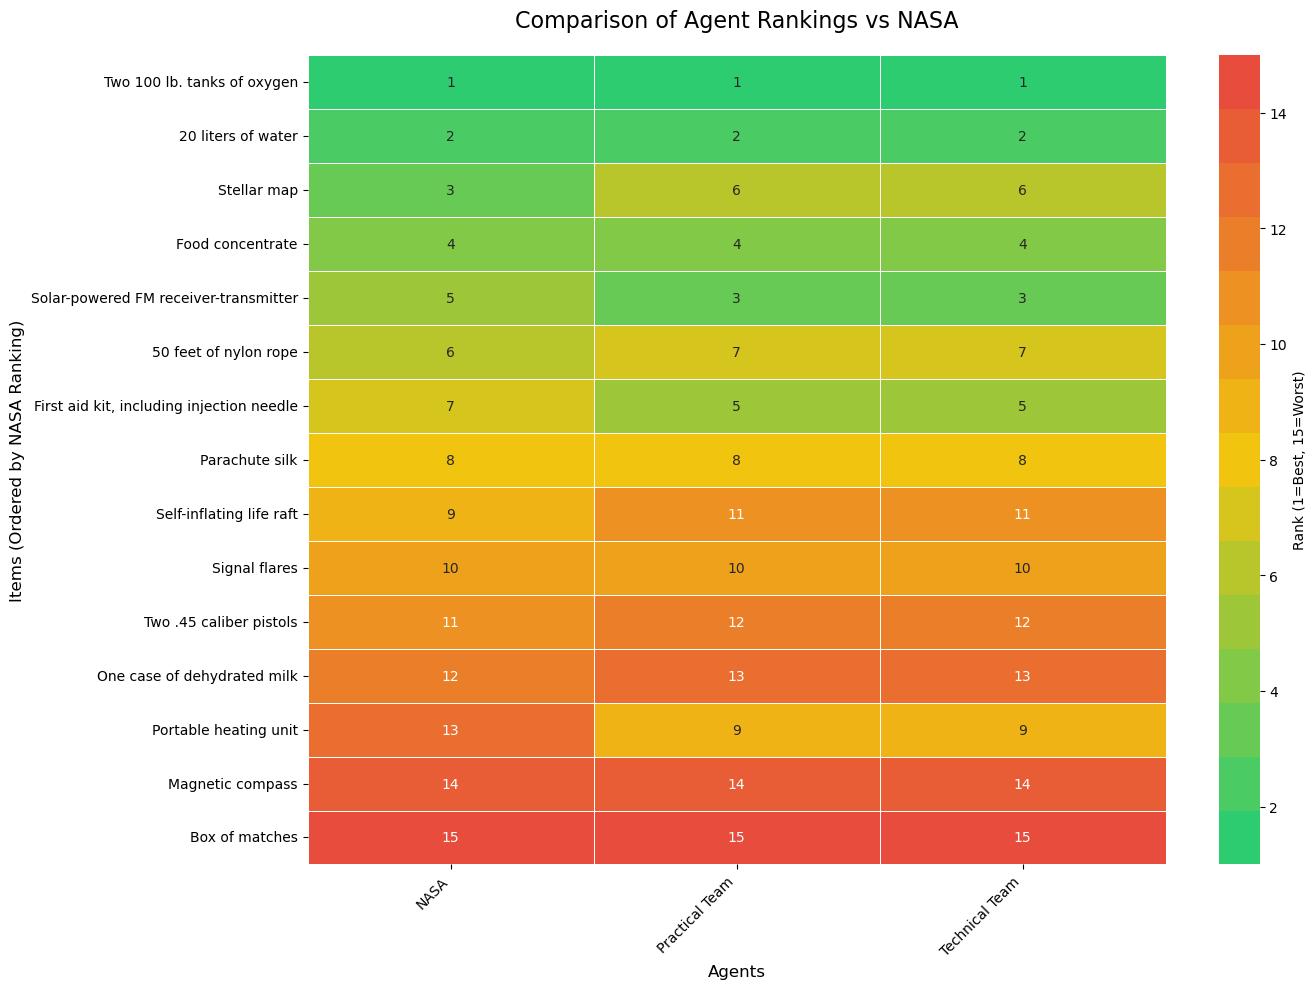

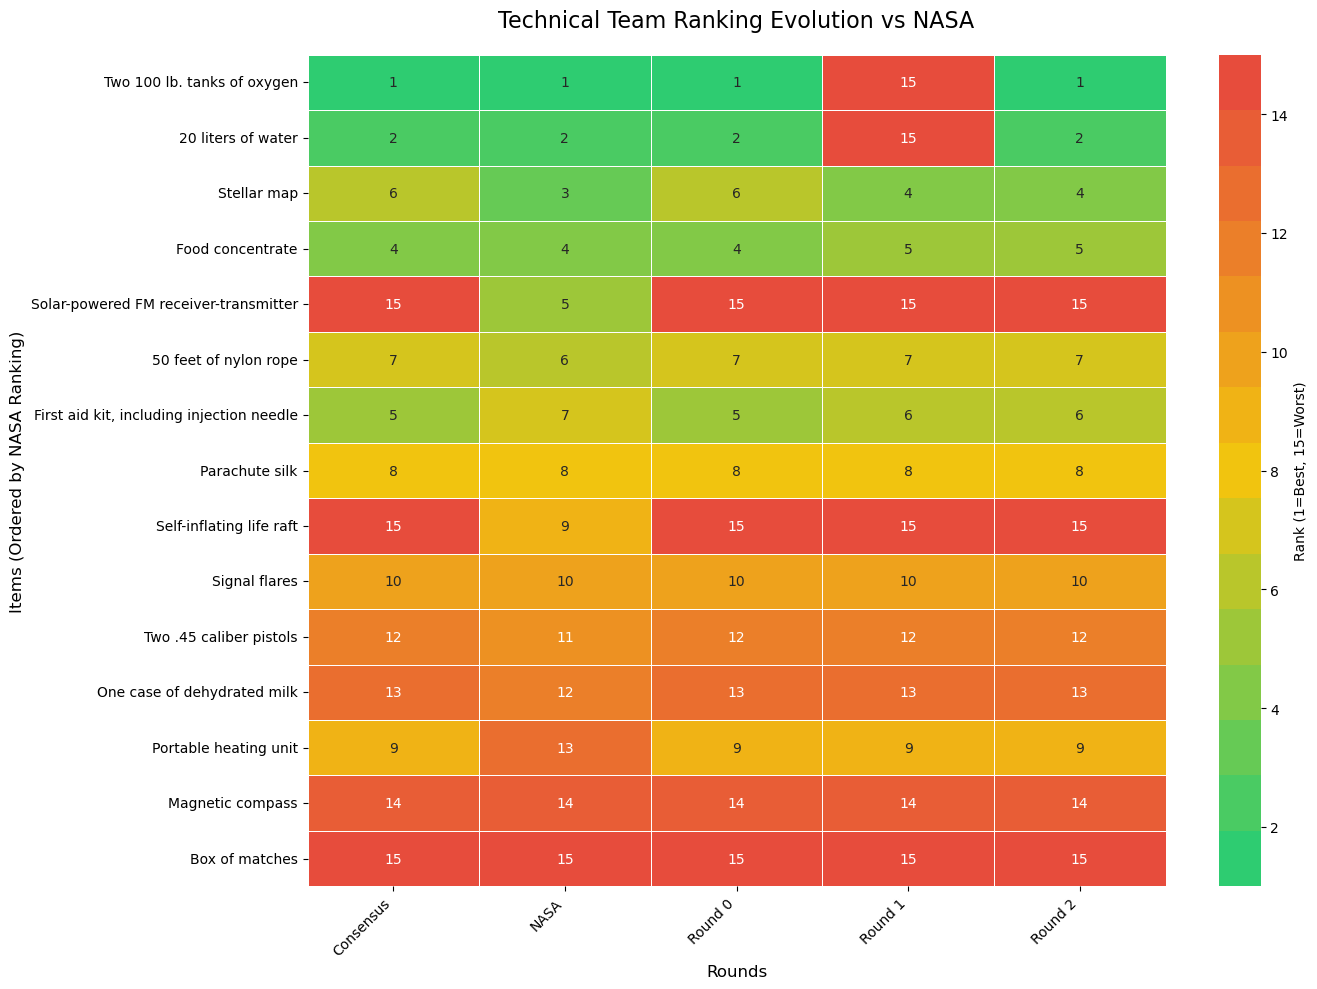

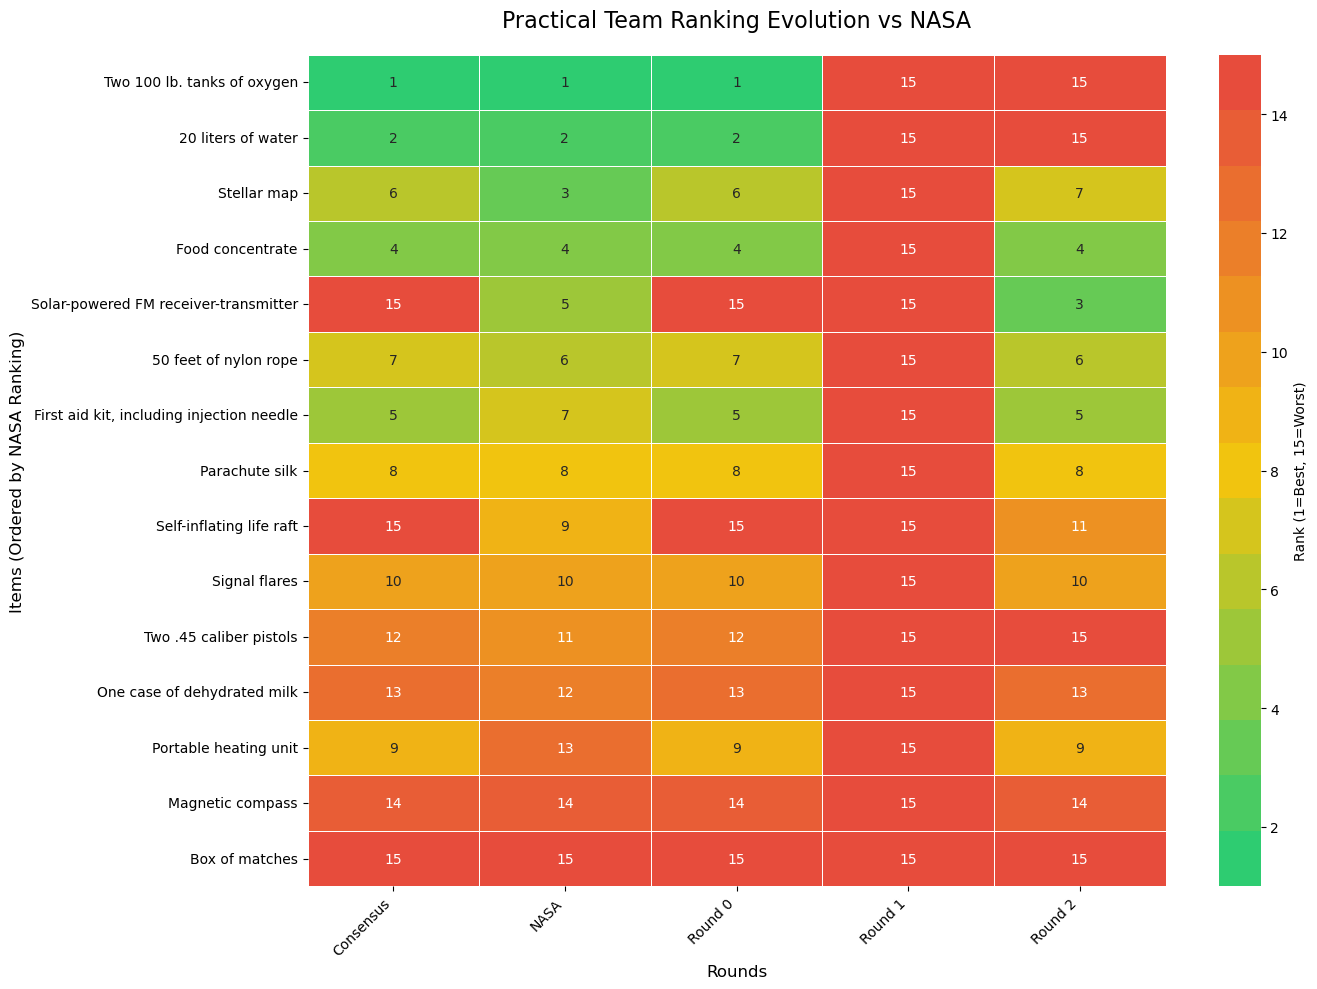

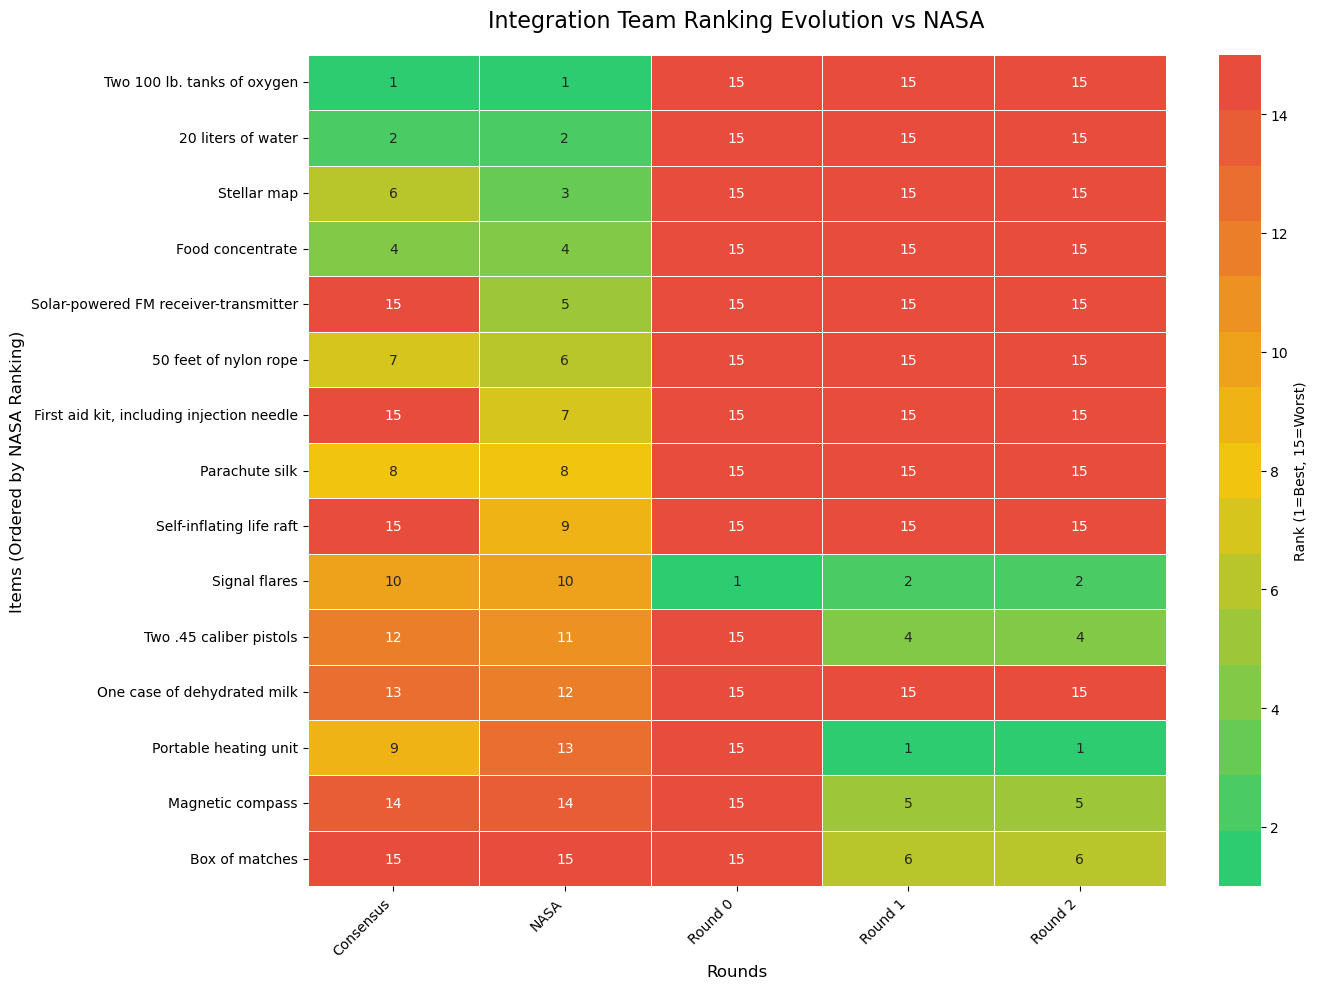

In [11]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def load_nasa_ranking():
    """Load NASA's official ranking for comparison."""
    nasa_ranking = [
        "Two 100 lb. tanks of oxygen",
        "20 liters of water", 
        "Stellar map",
        "Food concentrate",
        "Solar-powered FM receiver-transmitter",
        "50 feet of nylon rope",
        "First aid kit, including injection needle",
        "Parachute silk",
        "Self-inflating life raft",
        "Signal flares",
        "Two .45 caliber pistols",
        "One case of dehydrated milk",
        "Portable heating unit",
        "Magnetic compass",
        "Box of matches"
    ]
    
    # Convert to dict for easier comparison
    return {item: rank+1 for rank, item in enumerate(nasa_ranking)}

def extract_rankings_from_file(filename):
    """Extract rankings from a parsed ranking file."""
    rankings = []
    
    try:
        with open(filename, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Look for lines with "Rank X: Item"
            pattern = re.compile(r'Rank (\d+): (.+?)\n')
            matches = pattern.findall(content)
            
            for rank_str, item_name in matches:
                rankings.append({
                    "rank": int(rank_str), 
                    "name": item_name.strip()
                })
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")
        
    return rankings

def extract_rankings_from_json(filename):
    """Extract rankings from saved JSON file."""
    try:
        with open(filename, "r", encoding="utf-8") as f:
            data = json.load(f)
            return data
    except (FileNotFoundError, json.JSONDecodeError):
        print(f"Warning: JSON file {filename} not found or invalid.")
        return []

def extract_rankings_from_text(filename, round_num=None):
    """Extract rankings from full discussion text by round."""
    rankings_by_round = {}
    current_round = None
    current_content = []
    
    try:
        with open(filename, "r", encoding="utf-8") as f:
            content = f.read()
            
            # Split by round
            rounds = re.split(r'Round: (\d+|consensus)', content)
            
            # Process each round
            for i in range(1, len(rounds), 2):
                round_id = rounds[i]
                round_content = rounds[i+1]
                
                # Extract rankings
                # Look for patterns like "1. Two 100 lb. Tanks of Oxygen"
                pattern = re.compile(r'(\d+)[.]\s+(?:\*\*)?([^*\n]+?)(?:\*\*)?(?:[\s]*[-:]|$)')
                matches = pattern.findall(round_content)
                
                round_rankings = []
                for rank_str, item_name in matches:
                    round_rankings.append({
                        "rank": int(rank_str),
                        "name": item_name.strip()
                    })
                
                if round_rankings:
                    rankings_by_round[round_id] = round_rankings
    
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")
    
    # Return specific round if requested, otherwise all rounds
    if round_num is not None and str(round_num) in rankings_by_round:
        return rankings_by_round[str(round_num)]
    
    return rankings_by_round

def standardize_item_names(rankings, nasa_items):
    """Standardize item names to match NASA's names."""
    standardized = []
    
    for item in rankings:
        best_match = None
        best_score = 0
        
        for nasa_item in nasa_items.keys():
            # Calculate similarity score
            nasa_lower = nasa_item.lower()
            item_lower = item["name"].lower()
            
            # Check for direct containment
            if nasa_lower in item_lower or item_lower in nasa_lower:
                score = len(set(nasa_lower.split()) & set(item_lower.split())) / len(set(nasa_lower.split()))
                if score > best_score:
                    best_score = score
                    best_match = nasa_item
        
        if best_match and best_score > 0.3:
            standardized.append({
                "rank": item["rank"],
                "name": best_match
            })
        else:
            # Keep original if no good match
            standardized.append(item)
    
    return standardized

def create_comparison_visualization(rankings_dict, nasa_ranking, output_file="agent_comparison.png"):
    """Create a visualization comparing different agent rankings."""
    print("Creating comparison visualization...")
    
    # Prepare data
    items = list(nasa_ranking.keys())
    agents = list(rankings_dict.keys()) + ["NASA"]
    
    # Create a DataFrame with all rankings
    data = []
    
    # Add NASA's rankings
    for item, rank in nasa_ranking.items():
        data.append({
            "Agent": "NASA",
            "Item": item,
            "Rank": rank
        })
    
    # Add each agent's rankings
    for agent, rankings in rankings_dict.items():
        # Convert to dictionary for easier lookup
        rank_dict = {item["name"]: item["rank"] for item in rankings}
        
        for item in items:
            if item in rank_dict:
                data.append({
                    "Agent": agent,
                    "Item": item,
                    "Rank": rank_dict[item]
                })
            else:
                # If item not found in agent's ranking
                data.append({
                    "Agent": agent,
                    "Item": item,
                    "Rank": 15  # Default to lowest rank
                })
    
    df = pd.DataFrame(data)
    
    # Create a pivot table for the heatmap
    pivot = df.pivot(index="Item", columns="Agent", values="Rank")
    
    # Sort items by NASA ranking
    nasa_order = [item for item, _ in sorted(nasa_ranking.items(), key=lambda x: x[1])]
    pivot = pivot.reindex(nasa_order)
    
    # Setup the plot
    plt.figure(figsize=(14, 10))
    
    # Custom colormap from green (good) to red (bad)
    colors = ['#2ecc71', '#f1c40f', '#e74c3c']  # green, yellow, red
    cmap = LinearSegmentedColormap.from_list('rank_cmap', colors, N=15)
    
    # Create the heatmap
    ax = sns.heatmap(pivot, annot=True, cmap=cmap, linewidths=0.5, fmt=".0f",
                    cbar_kws={'label': 'Rank (1=Best, 15=Worst)'})
    
    # Customize the plot
    plt.title("Comparison of Agent Rankings vs NASA", fontsize=16, pad=20)
    plt.ylabel("Items (Ordered by NASA Ranking)", fontsize=12)
    plt.xlabel("Agents", fontsize=12)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha="right")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Comparison visualization saved to {output_file}")
    
    return pivot

def create_evolution_visualizations(agent_rounds, nasa_ranking, output_prefix="agent_evolution"):
    """Create visualizations showing how each agent's rankings evolved."""
    print("Creating evolution visualizations...")
    
    # For each agent
    for agent, rounds in agent_rounds.items():
        if len(rounds) <= 1:
            print(f"Skipping {agent} - not enough rounds")
            continue
            
        # Setup the plot
        plt.figure(figsize=(14, 10))
        
        # Prepare data
        items = list(nasa_ranking.keys())
        round_keys = sorted(rounds.keys(), key=lambda x: 0 if x == 'consensus' else int(x))
        
        # Create a DataFrame with all rounds
        data = []
        
        # Add each round's rankings
        for round_id in round_keys:
            rankings = rounds[round_id]
            # Convert to dictionary for easier lookup
            rank_dict = {item["name"]: item["rank"] for item in rankings}
            
            for item in items:
                if item in rank_dict:
                    data.append({
                        "Round": f"Round {round_id}" if round_id != 'consensus' else 'Consensus',
                        "Item": item,
                        "Rank": rank_dict[item]
                    })
                else:
                    # If item not found in this round
                    data.append({
                        "Round": f"Round {round_id}" if round_id != 'consensus' else 'Consensus',
                        "Item": item,
                        "Rank": 15  # Default to lowest rank
                    })
        
        # Add NASA's rankings for reference
        for item, rank in nasa_ranking.items():
            data.append({
                "Round": "NASA",
                "Item": item,
                "Rank": rank
            })
        
        df = pd.DataFrame(data)
        
        # Create a pivot table for the heatmap
        pivot = df.pivot(index="Item", columns="Round", values="Rank")
        
        # Sort items by NASA ranking
        nasa_order = [item for item, _ in sorted(nasa_ranking.items(), key=lambda x: x[1])]
        pivot = pivot.reindex(nasa_order)
        
        # Custom colormap from green (good) to red (bad)
        colors = ['#2ecc71', '#f1c40f', '#e74c3c']  # green, yellow, red
        cmap = LinearSegmentedColormap.from_list('rank_cmap', colors, N=15)
        
        # Create the heatmap
        ax = sns.heatmap(pivot, annot=True, cmap=cmap, linewidths=0.5, fmt=".0f",
                        cbar_kws={'label': 'Rank (1=Best, 15=Worst)'})
        
        # Customize the plot
        plt.title(f"{agent} Ranking Evolution vs NASA", fontsize=16, pad=20)
        plt.ylabel("Items (Ordered by NASA Ranking)", fontsize=12)
        plt.xlabel("Rounds", fontsize=12)
        
        # Rotate x-axis labels
        plt.xticks(rotation=45, ha="right")
        
        # Adjust layout
        plt.tight_layout()
        
        # Save the figure
        output_file = f"{output_prefix}_{agent.replace(' ', '_')}.png"
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Evolution visualization for {agent} saved to {output_file}")
    
    return agent_rounds

def analyze_agent_performance(agent_scores, nasa_ranking):
    """Analyze each agent's performance against NASA ranking."""
    results = {}
    
    for agent, rankings in agent_scores.items():
        total_score = 0
        for item in rankings:
            nasa_rank = nasa_ranking.get(item["name"], 15)
            difference = abs(nasa_rank - item["rank"])
            total_score += difference
        
        results[agent] = total_score
    
    return results

def main():
    """Main function to generate all visualizations."""
    print("Analyzing Lunar Survival Challenge Results...")
    
    # Load NASA ranking
    nasa_ranking = load_nasa_ranking()
    
    # Extract final rankings from each agent/team
    final_rankings = {}
    
    # Technical Team from technical_ranking_parsed.txt
    tech_rankings = extract_rankings_from_file("technical_ranking_parsed.txt")
    if tech_rankings:
        final_rankings["Technical Team"] = standardize_item_names(tech_rankings, nasa_ranking)
    
    # Practical Team from practical_ranking_parsed.txt
    prac_rankings = extract_rankings_from_file("practical_ranking_parsed.txt")
    if prac_rankings:
        final_rankings["Practical Team"] = standardize_item_names(prac_rankings, nasa_ranking)
    
    # Meta Reasoning from meta_reasoning_response.txt
    meta_rankings = extract_rankings_from_text("meta_reasoning_response.txt")
    if 'consensus' in meta_rankings:
        final_rankings["Meta Reasoning"] = standardize_item_names(meta_rankings['consensus'], nasa_ranking)
    
    # Final rankings from final_rankings_comparison.txt
    final_compare = extract_rankings_from_file("final_rankings_comparison.txt")
    if final_compare:
        final_rankings["Final System"] = standardize_item_names(final_compare, nasa_ranking)
    
    # JSON files for technical and practical teams
    try:
        tech_json = extract_rankings_from_json("technical_team_ranking.json")
        if tech_json and not "Technical Team" in final_rankings:
            final_rankings["Technical Team"] = standardize_item_names(tech_json, nasa_ranking)
    except Exception as e:
        print(f"Error processing technical_team_ranking.json: {e}")
    
    try:
        prac_json = extract_rankings_from_json("practical_team_ranking.json")
        if prac_json and not "Practical Team" in final_rankings:
            final_rankings["Practical Team"] = standardize_item_names(prac_json, nasa_ranking)
    except Exception as e:
        print(f"Error processing practical_team_ranking.json: {e}")
    
    # Extract rankings by round for evolution visualization
    agent_rounds = {}
    
    # Technical Team evolution
    tech_rounds = extract_rankings_from_text("technical_reasoning_full_discussion.txt")
    if tech_rounds:
        agent_rounds["Technical Team"] = {k: standardize_item_names(v, nasa_ranking) for k, v in tech_rounds.items()}
    
    # Practical Team evolution
    prac_rounds = extract_rankings_from_text("practical_reasoning_full_discussion.txt")
    if prac_rounds:
        agent_rounds["Practical Team"] = {k: standardize_item_names(v, nasa_ranking) for k, v in prac_rounds.items()}
    
    # Cross team integration evolution
    cross_rounds = extract_rankings_from_text("cross_team_integration_discussion.txt")
    if cross_rounds:
        agent_rounds["Integration Team"] = {k: standardize_item_names(v, nasa_ranking) for k, v in cross_rounds.items()}
    
    # Create comparison visualization
    if final_rankings:
        pivot = create_comparison_visualization(final_rankings, nasa_ranking)
        
        # Analyze scores
        scores = analyze_agent_performance(final_rankings, nasa_ranking)
        print("\nAgent Scores (lower is better):")
        for agent, score in sorted(scores.items(), key=lambda x: x[1]):
            print(f"- {agent}: {score}")
    
    # Create evolution visualizations
    if agent_rounds:
        create_evolution_visualizations(agent_rounds, nasa_ranking)
    
    print("\nAll visualizations complete!")

if __name__ == "__main__":
    main()